# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

In [3]:
#data = np.load("/kaggle/input/mars-for-students/mars_for_students.npz")
data = np.load("mars_for_students_cleaned.npz")

#X_train = data['X_train']
#y_train = data['y_train']

#X_test = data["X_test"]

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]


X_train = tf.clip_by_value(X_train[..., np.newaxis] / 255.0 * 1.5, 0.0, 1.0)
y_train = y_train[..., np.newaxis]
X_test  = tf.clip_by_value(X_test[..., np.newaxis] / 255.0 * 1.5, 0.0, 1.0)

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128, 1)
Training y shape: (2505, 64, 128, 1)
Test X shape: (10022, 64, 128, 1)


## Prepare the data


In [4]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [5]:
LEARNING_RATE = 5e-3
EPOCHS = 1000
PATIENCE = 30
BATCH_SIZE = 64
SPLITS_SIZE = 300
SEED = 42
NUM_CLASSES = 5

X_train = X_train.numpy() if isinstance(X_train, tf.Tensor) else np.array(X_train)
y_train = y_train.numpy() if isinstance(y_train, tf.Tensor) else np.array(y_train)

from sklearn.model_selection import train_test_split

#train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
#    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
#)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)


print(f"Train set shape: {train_img.shape}")
print(f"Validation image set shape: {val_img.shape}")
print(f"Validation masks set shape: {val_lbl.shape}")
# print(f"Test set shape: {test_img.shape}")




Train set shape: (2205, 64, 128, 1)
Validation image set shape: (300, 64, 128, 1)
Validation masks set shape: (300, 64, 128, 1)


## Augmentation

In [6]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label

from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    # dataset = dataset.map(
    #     lambda x, y: (x, apply_category_mapping(y)),
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    if augment:

        augmentations = A.Compose([
            #A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Flip(),
            # A.Transpose(),
            #A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                #A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
            A.RandomGridShuffle(grid = (3,3), always_apply=False, p = 0.3),
            A.RandomBrightnessContrast(brightness_limit = 0.2,
                                        contrast_limit = 0.2,
                                        always_apply = False,
                                        p = 0.2
                                      ),
            #A.Sharpen(alpha=(0.2, 0.5), lightness = (0.5, 1.0), always_apply=False, p = 0.5),
            A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
            # A.RandomCrop(height=64, width=128, p=1),
            # A.OneOf([
            #     #A.CLAHE(clip_limit=2),
            #     A.RandomBrightnessContrast(),
            # ], p=0.3),
            # A.HueSaturationValue(p=0.3),
        ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

#test_dataset = make_dataset(
#    test_img, test_lbl,
#    batch_size=BATCH_SIZE,
#    shuffle=False
#)
print("Datasets created!")

def remove_extra_dim(images, labels):
    labels = tf.squeeze(labels, axis=-1)  # Supprime la dimension supplémentaire
    return images, labels

train_dataset = train_dataset.map(remove_extra_dim)

val_dataset = val_dataset.map(remove_extra_dim)

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break




Creating datasets...


<ipython-input-6-37951b13ec91>:120: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-6-37951b13ec91>:120: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-6-37951b13ec91>:120: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)


WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'float32'>


## Metric for simulation

In [8]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=(64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

# Model

In [12]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = tfkl.Conv2D(filters, kernel_size=(num_row, num_col), strides=strides, padding=padding, use_bias=False, name=name)(x)
    x = tfkl.BatchNormalization(axis=3, scale=False)(x)

    if activation is None:
        return x

    x = tfkl.Activation(activation, name=name)(x)
    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = tfkl.Conv2DTranspose(filters, kernel_size=(num_row, num_col), strides=strides, padding=padding)(x)
    x = tfkl.BatchNormalization(axis=3, scale=False)(x)
    return x


def MultiResBlock(U, inp, alpha=1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corresponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) + int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3, activation='relu', padding='same')
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3, activation='relu', padding='same')
    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3, activation='relu', padding='same')

    out = tfkl.concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = tfkl.BatchNormalization(axis=3)(out)

    out = tfkl.add([shortcut, out])
    out = tfkl.Activation('relu')(out)
    out = tfkl.BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- number of filters
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = tfkl.add([shortcut, out])
    out = tfkl.Activation('relu')(out)
    out = tfkl.BatchNormalization(axis=3)(out)

    for i in range(length - 1):
        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = tfkl.add([shortcut, out])
        out = tfkl.Activation('relu')(out)
        out = tfkl.BatchNormalization(axis=3)(out)

    return out

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tfkl.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    return x

class RepeatElementsLayer(tfk.Layer):
    def __init__(self, rep, axis=3, **kwargs):
        super(RepeatElementsLayer, self).__init__(**kwargs)
        self.rep = rep
        self.axis = axis

    def call(self, inputs):
        return tf.keras.backend.repeat_elements(inputs, self.rep, axis=self.axis)

    def get_config(self):
        config = super(RepeatElementsLayer, self).get_config()
        config.update({
            "rep": self.rep,
            "axis": self.axis
        })
        return config

def attention_block(x, gating, inter_shape):
    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = tfk.backend.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tfkl.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tfkl.add([upsample_g, theta_x])
    act_xg = tfkl.Activation('relu')(concat_xg)
    psi = tfkl.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tfkl.Activation('sigmoid')(psi)
    shape_sigmoid = tfk.backend.int_shape(sigmoid_xg)
    upsample_psi = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    repeat_layer = RepeatElementsLayer(rep= shape_x[3])
    upsample_psi = repeat_layer(upsample_psi)

    y = tfkl.multiply([upsample_psi, x])

    result = tfkl.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tfkl.BatchNormalization()(result)
    return result_bn


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''

    inputs = tfk.Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    gating_res4 = gating_signal(mresblock5, 32*8)
    att_res4 = attention_block(mresblock4, gating_res4, 32*8)
    up6 = tfkl.concatenate([tfkl.Conv2DTranspose(32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), att_res4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    gating_res3 = gating_signal(mresblock6, 32*4)
    att_res3 = attention_block(mresblock3, gating_res3, 32*4)
    up7 = tfkl.concatenate([tfkl.Conv2DTranspose(32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), att_res3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    gating_res2 = gating_signal(mresblock7, 32*2)
    att_res2 = attention_block(mresblock2, gating_res2, 32*2)
    up8 = tfkl.concatenate([tfkl.Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), att_res2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    gating_res1 = gating_signal(mresblock8, 32)
    att_res1 = attention_block(mresblock1, gating_res1, 32)
    up9 = tfkl.concatenate([tfkl.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(mresblock8), att_res1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 5, 1, 1, activation='softmax')

    model = tfk.Model(inputs=[inputs], outputs=[conv10])

    return model


model = MultiResUnet(64,128, 1)
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=70)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 128, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_122 (Conv2D)       │ (None, 64, 128, 8)     │             72 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_150   │ (None, 64, 128, 8)     │             24 │ conv2d_122[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_112            │ (None, 64, 128, 8)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_123 (Conv2D)       │ (None, 64, 128, 17)    │          1,224 │ activation_112[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_151   │ (None, 64, 128, 17)    │             51 │ conv2d_123[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_113            │ (None, 64, 128, 17)    │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_124 (Conv2D)       │ (None, 64, 128, 26)    │          3,978 │ activation_113[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_152   │ (None, 64, 128, 26)    │             78 │ conv2d_124[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_114            │ (None, 64, 128, 26)    │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 64, 128, 51)    │             51 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18            │ (None, 64, 128, 51)    │              0 │ activation_112[0][0],  │
│ (Concatenate)             │                        │                │ activation_113[0][0],  │
│                           │                        │                │ activation_114[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_149   │ (None, 64, 128, 51)    │            153 │ conv2d_121[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_153   │ (None, 64, 128, 51)    │            204 │ concatenate_18[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 8,862,948 (33.81 MB)

 Trainable params: 8,837,458 (33.71 MB)

 Non-trainable params: 25,490 (99.57 KB)

## Loss

In [13]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Paramètres de base
initial_learning_rate = LEARNING_RATE  # Taux d'apprentissage initial
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=6*BATCH_SIZE,  # Nombre d'epochs ou de batches avant que le taux d'apprentissage diminue
    decay_rate=0.9,     # Facteur par lequel le taux d'apprentissage diminue chaque fois
    staircase=True       # Si True, le taux d'apprentissage est mis à jour après chaque étape (et non pas de manière continue)
)


def dice_loss(y_true, y_pred, smooth=1):
    """
    Dice loss function, ignoring class 0.
    """
    # Convert true labels to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)  # Assume 5 classes including background

    # Ignore class 0 by slicing the tensor
    y_true_one_hot = y_true_one_hot[..., 1:]  # Exclude the first channel (class 0)
    y_pred = y_pred[..., 1:]  # Exclude the predictions for class 0

    # Flatten the tensors
    y_true_f = K.flatten(y_true_one_hot)
    y_pred_f = K.flatten(y_pred)

    # Compute Dice coefficient
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    dice = (2.0 * intersection + smooth) / (union + smooth)

    return 1.0 - dice

def combined_loss(weight_dice=0.25):
    """
    Combine Dice Loss et Sparse Categorical Cross Entropy.

    :param weight_dice: Poids de la perte Dice dans la combinaison.
    :return: Une fonction de perte personnalisée compatible avec Keras.
    """
    bce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0)

    def loss_fn(y_true, y_pred):
        """
        Fonction interne pour combiner Dice Loss et BCE.
        """
        # Calcul de la BCE
        loss_bce = bce(y_true, y_pred)

        # Calcul de la Dice Loss
        loss_dice = dice_loss(y_true, y_pred)

        # Combinaison des pertes
        loss_comb = weight_dice * loss_dice + (1 - weight_dice) * loss_bce
        return loss_comb

    return loss_fn

# Création de l'optimiseur avec ce scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)


model.compile(
    loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0),
    optimizer=optimizer,
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

In [14]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def weighted_iou_loss(y_true, y_pred, epsilon=1e-6):
    """
    Computes the weighted IoU loss.

    Arguments:
    - y_true: Ground truth masks.
    - y_pred: Predicted masks.
    - epsilon: Small constant to avoid division by zero.

    Returns:
    - Weighted IoU loss.
    """

    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)  # 5 classes pour la segmentation

    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return 1 - iou

def weighted_bce_loss(y_true, y_pred):
    """
    Computes the weighted BCE loss.

    Arguments:
    - y_true: Ground truth labels.
    - y_pred: Predicted probabilities.

    Returns:
    - Weighted BCE loss.
    """
    bce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    return bce(y_true, y_pred)

def custom_loss(y_true, y_pred):
    """
    Computes the combined weighted IoU and BCE loss.

    Arguments:
    - y_true: Ground truth masks.
    - y_pred: Predicted masks.

    Returns:
    - Combined weighted IoU and BCE loss.
    """
    print(y_true.shape,y_pred.shape )
    iou_loss = weighted_iou_loss(y_true, y_pred)
    bce_loss = weighted_bce_loss(y_true, y_pred)
    return iou_loss + bce_loss


# from the document but how to use it ?
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union


Epoch 1/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3240 - loss: 1.5122 - mean_iou: 0.1645   

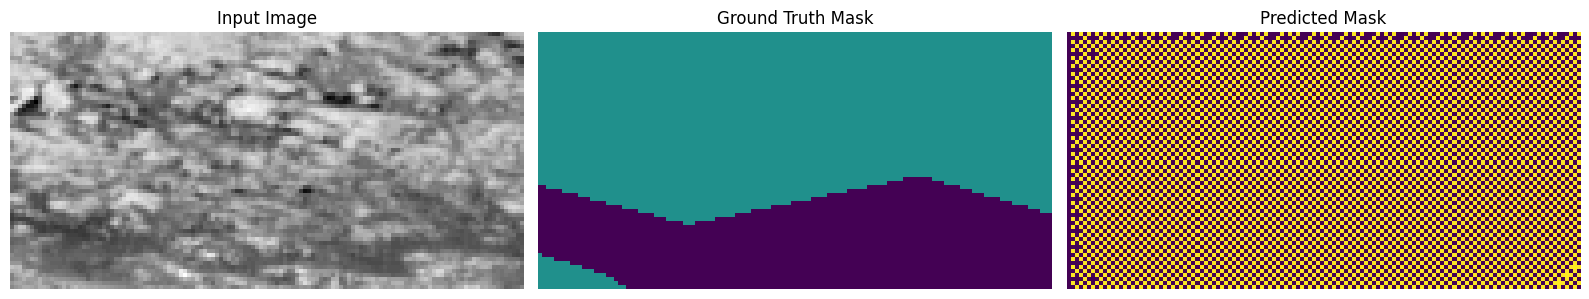

35/35 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.3248 - loss: 1.5087 - mean_iou: 0.1651 - val_accuracy: 0.1241 - val_loss: 16.1127 - val_mean_iou: 1.3640e-04
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 553ms/step - accuracy: 0.4119 - loss: 1.1770 - mean_iou: 0.2328 - val_accuracy: 0.2309 - val_loss: 10.7313 - val_mean_iou: 0.0109
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 547ms/step - accuracy: 0.4748 - loss: 1.0177 - mean_iou: 0.2835 - val_accuracy: 0.0222 - val_loss: 15.2083 - val_mean_iou: 0.0163
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 546ms/step - accuracy: 0.5283 - loss: 0.8784 - mean_iou: 0.3286 - val_accuracy: 0.2171 - val_loss: 11.4850 - val_mean_iou: 0.0715
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.5494 - loss: 0.7936 - mean_iou: 0.3487 - val_accuracy: 0.2166 - val_loss: 5.6608 - val_mean_iou: 0.0583
Epoch 6/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.5518 - loss: 0.7730 - mean_iou: 0.3490

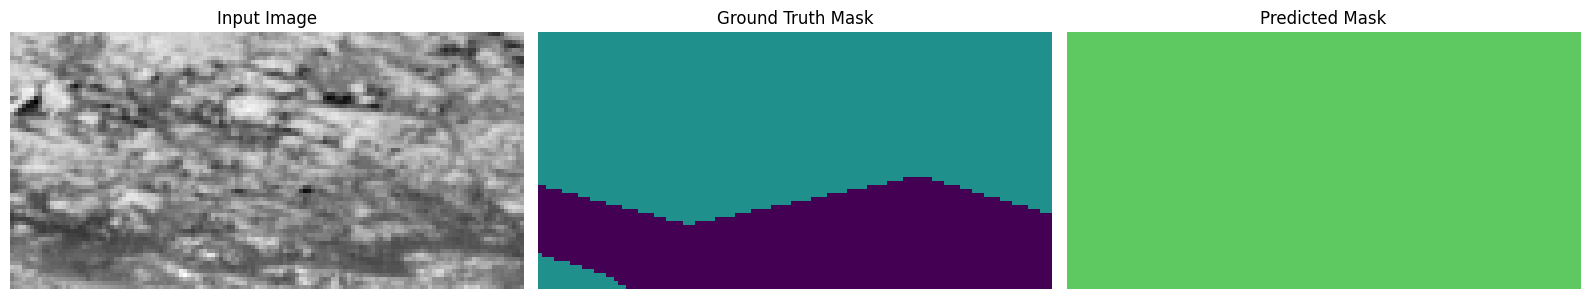

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 563ms/step - accuracy: 0.5519 - loss: 0.7727 - mean_iou: 0.3490 - val_accuracy: 0.2265 - val_loss: 9.8486 - val_mean_iou: 0.0793
Epoch 7/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 535ms/step - accuracy: 0.5617 - loss: 0.7029 - mean_iou: 0.3605 - val_accuracy: 0.2175 - val_loss: 5.3470 - val_mean_iou: 0.0721
Epoch 8/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 540ms/step - accuracy: 0.5770 - loss: 0.6681 - mean_iou: 0.3739 - val_accuracy: 0.3152 - val_loss: 3.2656 - val_mean_iou: 0.1230
Epoch 9/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - accuracy: 0.5839 - loss: 0.6458 - mean_iou: 0.3803 - val_accuracy: 0.2357 - val_loss: 5.2067 - val_mean_iou: 0.0886
Epoch 10/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 541ms/step - accuracy: 0.5911 - loss: 0.6144 - mean_iou: 0.3908 - val_accuracy: 0.3965 - val_loss: 1.8590 - val_mean_iou: 0.2317
Epoch 11/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.6006 - loss: 0.5915 - mean_iou: 0.4012

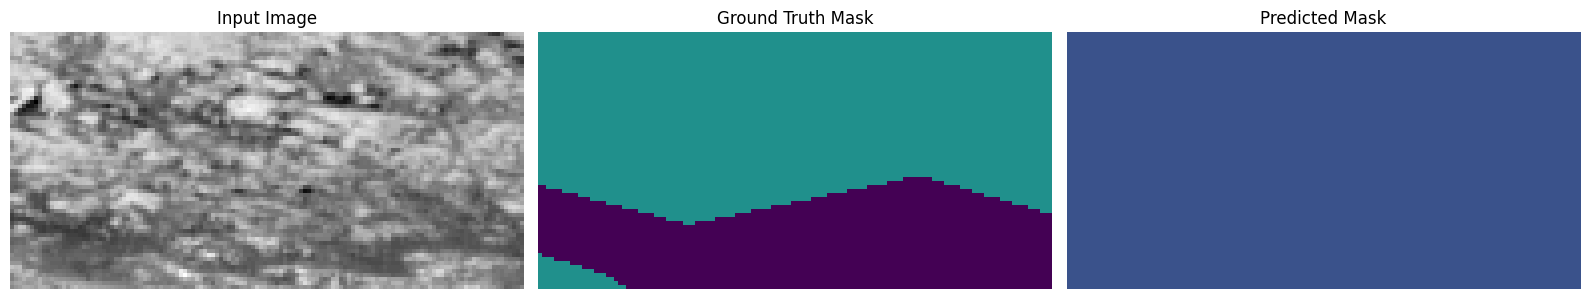

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.6007 - loss: 0.5914 - mean_iou: 0.4012 - val_accuracy: 0.5465 - val_loss: 0.9418 - val_mean_iou: 0.3141
Epoch 12/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 544ms/step - accuracy: 0.6107 - loss: 0.5506 - mean_iou: 0.4139 - val_accuracy: 0.4978 - val_loss: 1.0296 - val_mean_iou: 0.2609
Epoch 13/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.6150 - loss: 0.5382 - mean_iou: 0.4198 - val_accuracy: 0.4790 - val_loss: 0.8890 - val_mean_iou: 0.3230
Epoch 14/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6276 - loss: 0.5038 - mean_iou: 0.4325 - val_accuracy: 0.5758 - val_loss: 0.6936 - val_mean_iou: 0.4582
Epoch 15/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.6266 - loss: 0.4993 - mean_iou: 0.4323 - val_accuracy: 0.5779 - val_loss: 0.7168 - val_mean_iou: 0.4609
Epoch 16/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.6308 - loss: 0.4915 - mean_iou: 0.4391

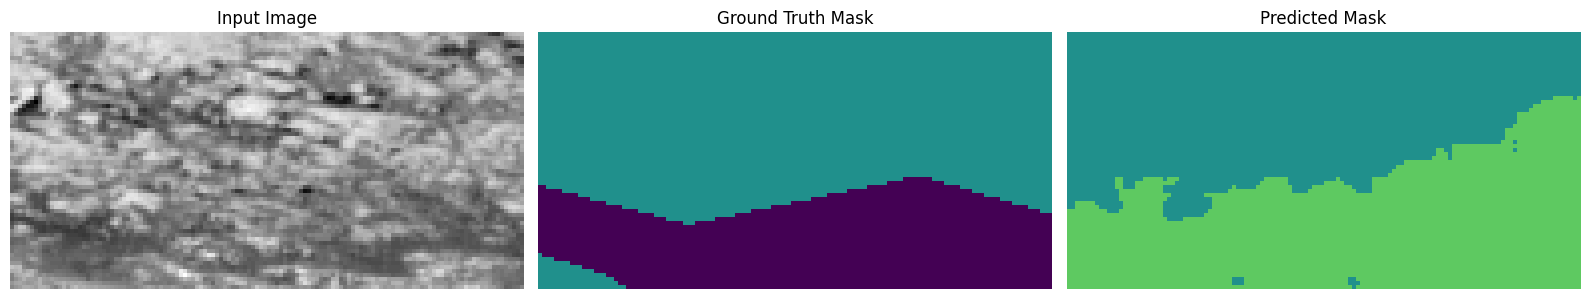

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step - accuracy: 0.6309 - loss: 0.4917 - mean_iou: 0.4390 - val_accuracy: 0.4964 - val_loss: 1.1145 - val_mean_iou: 0.3635
Epoch 17/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.6318 - loss: 0.4926 - mean_iou: 0.4393 - val_accuracy: 0.5829 - val_loss: 0.6766 - val_mean_iou: 0.4464
Epoch 18/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 558ms/step - accuracy: 0.6302 - loss: 0.4935 - mean_iou: 0.4352 - val_accuracy: 0.5932 - val_loss: 0.6097 - val_mean_iou: 0.4596
Epoch 19/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 544ms/step - accuracy: 0.6383 - loss: 0.4753 - mean_iou: 0.4480 - val_accuracy: 0.6195 - val_loss: 0.4961 - val_mean_iou: 0.5121
Epoch 20/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.6337 - loss: 0.4785 - mean_iou: 0.4432 - val_accuracy: 0.6509 - val_loss: 0.4310 - val_mean_iou: 0.4455
Epoch 21/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6386 - loss: 0.4590 - mean_iou: 0.4468

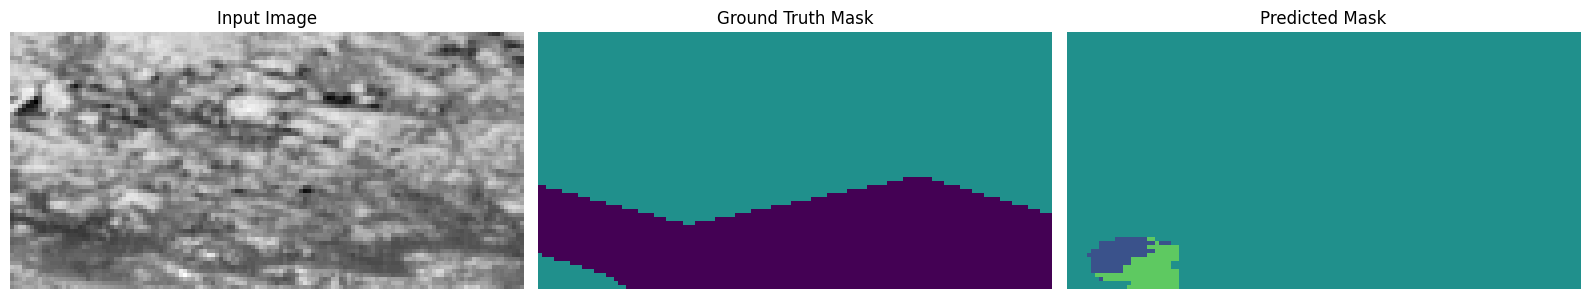

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 557ms/step - accuracy: 0.6387 - loss: 0.4593 - mean_iou: 0.4467 - val_accuracy: 0.6478 - val_loss: 0.4467 - val_mean_iou: 0.5451
Epoch 22/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6480 - loss: 0.4368 - mean_iou: 0.4686 - val_accuracy: 0.4761 - val_loss: 1.0046 - val_mean_iou: 0.3605
Epoch 23/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 541ms/step - accuracy: 0.6416 - loss: 0.4547 - mean_iou: 0.4505 - val_accuracy: 0.5438 - val_loss: 0.7304 - val_mean_iou: 0.4164
Epoch 24/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.6438 - loss: 0.4424 - mean_iou: 0.4528 - val_accuracy: 0.6605 - val_loss: 0.3973 - val_mean_iou: 0.4562
Epoch 25/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.6487 - loss: 0.4429 - mean_iou: 0.4699 - val_accuracy: 0.6419 - val_loss: 0.4457 - val_mean_iou: 0.4351
Epoch 26/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.6482 - loss: 0.4407 - mean_iou: 0.4680

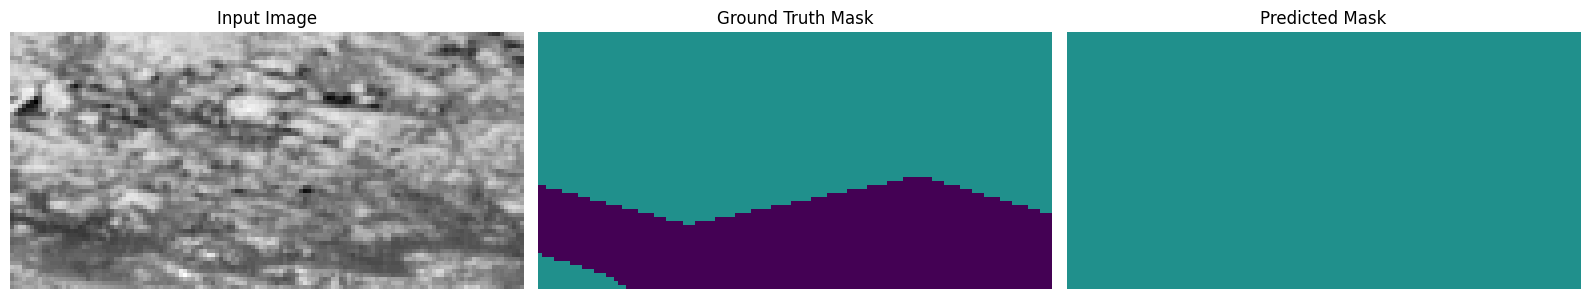

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 549ms/step - accuracy: 0.6485 - loss: 0.4406 - mean_iou: 0.4678 - val_accuracy: 0.6558 - val_loss: 0.4214 - val_mean_iou: 0.4523
Epoch 27/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.6537 - loss: 0.4211 - mean_iou: 0.4611 - val_accuracy: 0.6447 - val_loss: 0.4559 - val_mean_iou: 0.5521
Epoch 28/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step - accuracy: 0.6492 - loss: 0.4280 - mean_iou: 0.4623 - val_accuracy: 0.6557 - val_loss: 0.4306 - val_mean_iou: 0.5619
Epoch 29/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.6588 - loss: 0.4208 - mean_iou: 0.4688 - val_accuracy: 0.6417 - val_loss: 0.4719 - val_mean_iou: 0.5389
Epoch 30/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 541ms/step - accuracy: 0.6467 - loss: 0.4324 - mean_iou: 0.4566 - val_accuracy: 0.6391 - val_loss: 0.4558 - val_mean_iou: 0.5321
Epoch 31/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.6532 - loss: 0.4286 - mean_iou: 0.4670

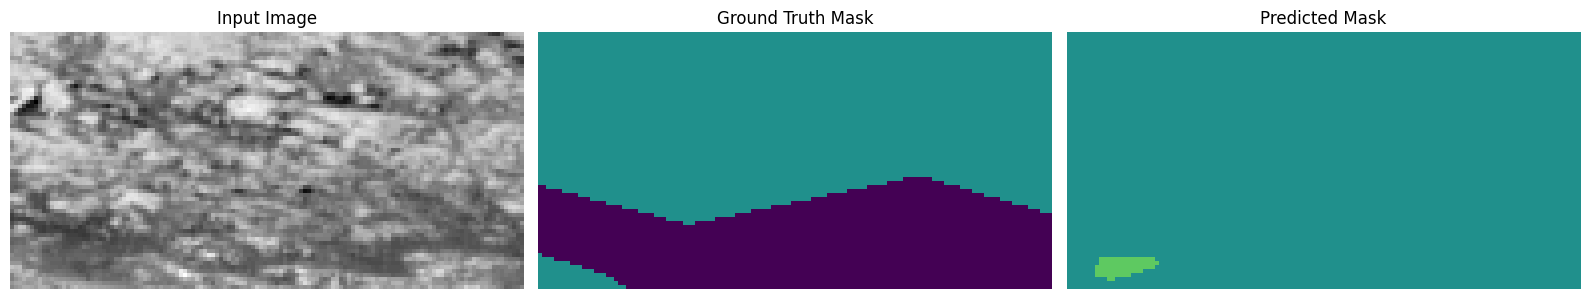

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 551ms/step - accuracy: 0.6533 - loss: 0.4289 - mean_iou: 0.4667 - val_accuracy: 0.5035 - val_loss: 0.8831 - val_mean_iou: 0.3914
Epoch 32/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 546ms/step - accuracy: 0.6560 - loss: 0.4095 - mean_iou: 0.4673 - val_accuracy: 0.6590 - val_loss: 0.4088 - val_mean_iou: 0.5734
Epoch 33/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.6522 - loss: 0.4119 - mean_iou: 0.4930 - val_accuracy: 0.6090 - val_loss: 0.5251 - val_mean_iou: 0.4939
Epoch 34/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.6554 - loss: 0.4113 - mean_iou: 0.4667 - val_accuracy: 0.6691 - val_loss: 0.3965 - val_mean_iou: 0.5849
Epoch 35/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.6563 - loss: 0.4160 - mean_iou: 0.4793 - val_accuracy: 0.6016 - val_loss: 0.6110 - val_mean_iou: 0.3985
Epoch 36/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.6611 - loss: 0.4046 - mean_iou: 0.4713

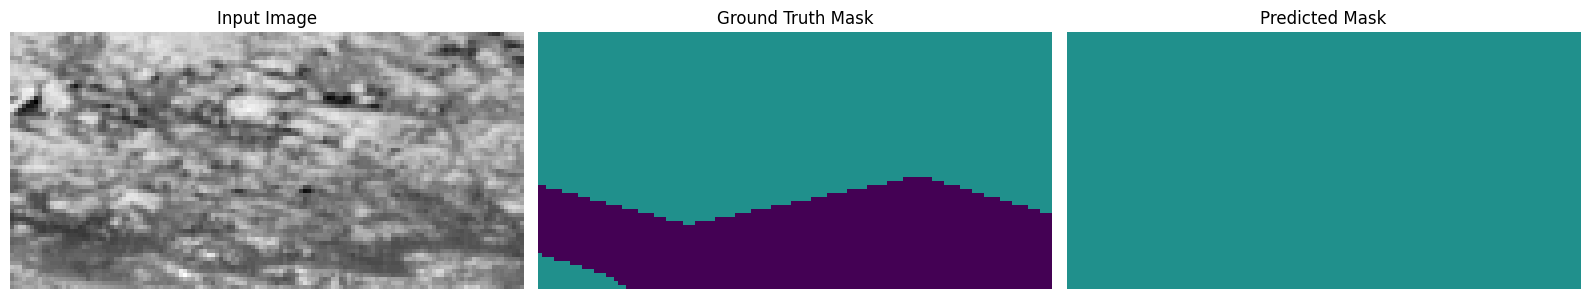

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 551ms/step - accuracy: 0.6611 - loss: 0.4050 - mean_iou: 0.4710 - val_accuracy: 0.6617 - val_loss: 0.4225 - val_mean_iou: 0.4610
Epoch 37/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.6607 - loss: 0.4079 - mean_iou: 0.4799 - val_accuracy: 0.4715 - val_loss: 0.8870 - val_mean_iou: 0.2730
Epoch 38/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6628 - loss: 0.3939 - mean_iou: 0.4756 - val_accuracy: 0.6670 - val_loss: 0.3944 - val_mean_iou: 0.5839
Epoch 39/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 541ms/step - accuracy: 0.6608 - loss: 0.3979 - mean_iou: 0.4746 - val_accuracy: 0.6590 - val_loss: 0.4186 - val_mean_iou: 0.5670
Epoch 40/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - accuracy: 0.6611 - loss: 0.3926 - mean_iou: 0.4767 - val_accuracy: 0.6454 - val_loss: 0.4408 - val_mean_iou: 0.4369
Epoch 41/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6605 - loss: 0.3974 - mean_iou: 0.5202

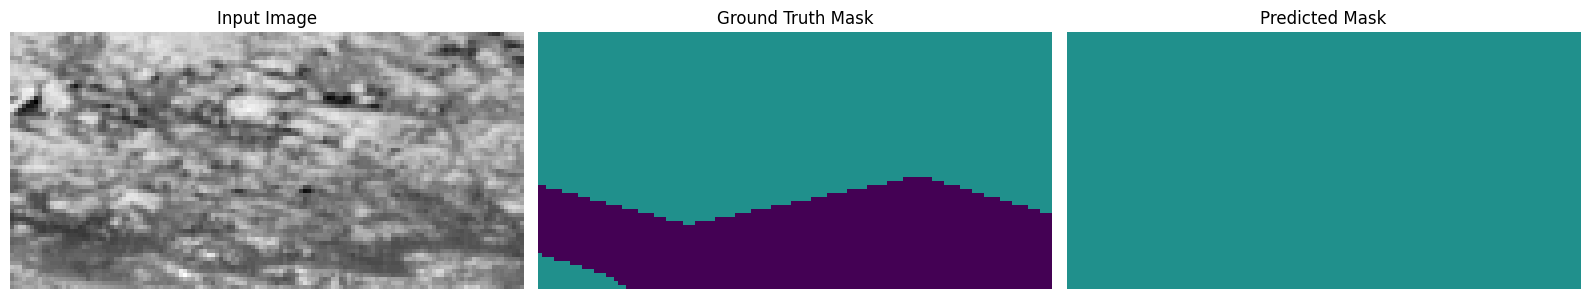

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 556ms/step - accuracy: 0.6607 - loss: 0.3976 - mean_iou: 0.5188 - val_accuracy: 0.5177 - val_loss: 0.8321 - val_mean_iou: 0.4133
Epoch 42/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 550ms/step - accuracy: 0.6626 - loss: 0.3929 - mean_iou: 0.4870 - val_accuracy: 0.6793 - val_loss: 0.3569 - val_mean_iou: 0.6025
Epoch 43/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.6640 - loss: 0.3864 - mean_iou: 0.5591 - val_accuracy: 0.6353 - val_loss: 0.4668 - val_mean_iou: 0.4355
Epoch 44/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 546ms/step - accuracy: 0.6621 - loss: 0.3889 - mean_iou: 0.4779 - val_accuracy: 0.5225 - val_loss: 0.7525 - val_mean_iou: 0.3183
Epoch 45/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.6713 - loss: 0.3764 - mean_iou: 0.5246 - val_accuracy: 0.6526 - val_loss: 0.4292 - val_mean_iou: 0.4545
Epoch 46/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.6658 - loss: 0.3809 - mean_iou: 0.6097

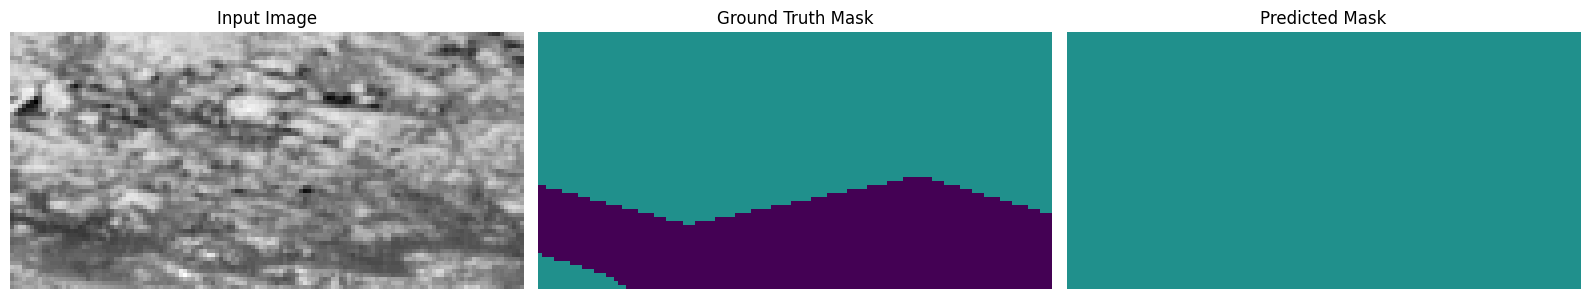

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.6660 - loss: 0.3810 - mean_iou: 0.6094 - val_accuracy: 0.6176 - val_loss: 0.5227 - val_mean_iou: 0.5209
Epoch 47/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.6603 - loss: 0.4022 - mean_iou: 0.5517 - val_accuracy: 0.6773 - val_loss: 0.3780 - val_mean_iou: 0.6009
Epoch 48/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step - accuracy: 0.6681 - loss: 0.3793 - mean_iou: 0.4968 - val_accuracy: 0.5875 - val_loss: 0.5842 - val_mean_iou: 0.4779
Epoch 49/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step - accuracy: 0.6767 - loss: 0.3580 - mean_iou: 0.5023 - val_accuracy: 0.6549 - val_loss: 0.4041 - val_mean_iou: 0.5685
Epoch 50/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.6672 - loss: 0.3729 - mean_iou: 0.5210 - val_accuracy: 0.6652 - val_loss: 0.3937 - val_mean_iou: 0.5817
Epoch 51/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6748 - loss: 0.3630 - mean_iou: 0.5133

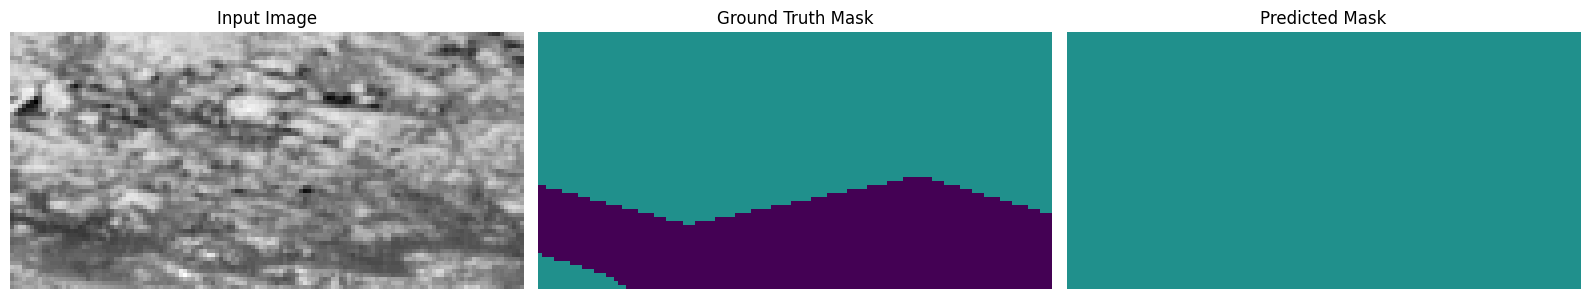

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 570ms/step - accuracy: 0.6749 - loss: 0.3632 - mean_iou: 0.5127 - val_accuracy: 0.6775 - val_loss: 0.3673 - val_mean_iou: 0.4808
Epoch 52/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 546ms/step - accuracy: 0.6708 - loss: 0.3691 - mean_iou: 0.5672 - val_accuracy: 0.6774 - val_loss: 0.3569 - val_mean_iou: 0.5977
Epoch 53/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.6675 - loss: 0.3799 - mean_iou: 0.5399 - val_accuracy: 0.6503 - val_loss: 0.4414 - val_mean_iou: 0.5625
Epoch 54/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 541ms/step - accuracy: 0.6654 - loss: 0.3835 - mean_iou: 0.5014 - val_accuracy: 0.6406 - val_loss: 0.4862 - val_mean_iou: 0.5543
Epoch 55/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 546ms/step - accuracy: 0.6603 - loss: 0.3881 - mean_iou: 0.4930 - val_accuracy: 0.6773 - val_loss: 0.3802 - val_mean_iou: 0.5995
Epoch 56/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.6710 - loss: 0.3686 - mean_iou: 0.5373

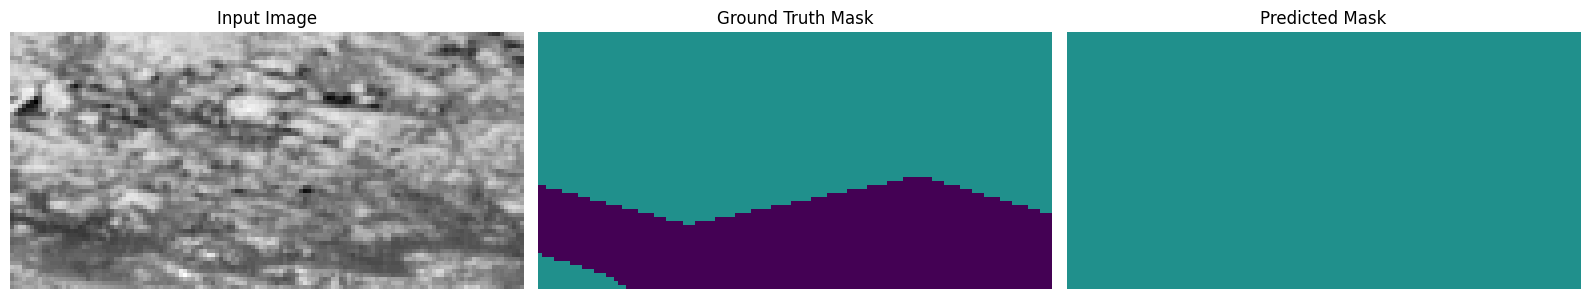

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.6711 - loss: 0.3689 - mean_iou: 0.5357 - val_accuracy: 0.6712 - val_loss: 0.3816 - val_mean_iou: 0.5909
Epoch 57/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6762 - loss: 0.3613 - mean_iou: 0.5971 - val_accuracy: 0.6804 - val_loss: 0.3571 - val_mean_iou: 0.6028
Epoch 58/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.6693 - loss: 0.3694 - mean_iou: 0.6141 - val_accuracy: 0.6621 - val_loss: 0.4099 - val_mean_iou: 0.5771
Epoch 59/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.6762 - loss: 0.3584 - mean_iou: 0.5301 - val_accuracy: 0.6649 - val_loss: 0.3933 - val_mean_iou: 0.5781
Epoch 60/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 542ms/step - accuracy: 0.6823 - loss: 0.3474 - mean_iou: 0.5357 - val_accuracy: 0.6426 - val_loss: 0.4613 - val_mean_iou: 0.5552
Epoch 61/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.6710 - loss: 0.3742 - mean_iou: 0.5630

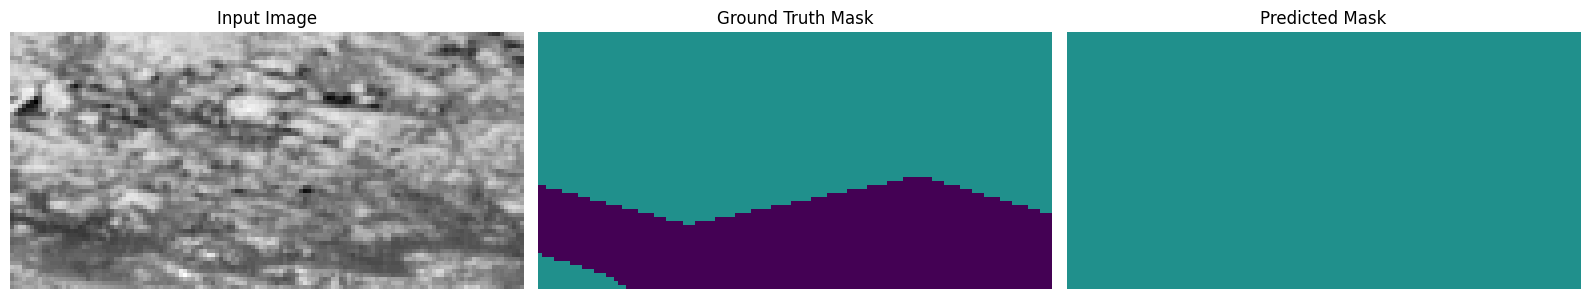

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.6711 - loss: 0.3743 - mean_iou: 0.5608 - val_accuracy: 0.6803 - val_loss: 0.3494 - val_mean_iou: 0.6028
Epoch 62/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.6719 - loss: 0.3691 - mean_iou: 0.6164 - val_accuracy: 0.5078 - val_loss: 0.8443 - val_mean_iou: 0.4011
Epoch 63/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.6776 - loss: 0.3550 - mean_iou: 0.5670 - val_accuracy: 0.6844 - val_loss: 0.3423 - val_mean_iou: 0.6107
Epoch 64/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 557ms/step - accuracy: 0.6804 - loss: 0.3522 - mean_iou: 0.5492 - val_accuracy: 0.6677 - val_loss: 0.4090 - val_mean_iou: 0.5891
Epoch 65/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 548ms/step - accuracy: 0.6750 - loss: 0.3659 - mean_iou: 0.5338 - val_accuracy: 0.6783 - val_loss: 0.3597 - val_mean_iou: 0.5992
Epoch 66/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6774 - loss: 0.3599 - mean_iou: 0.5059

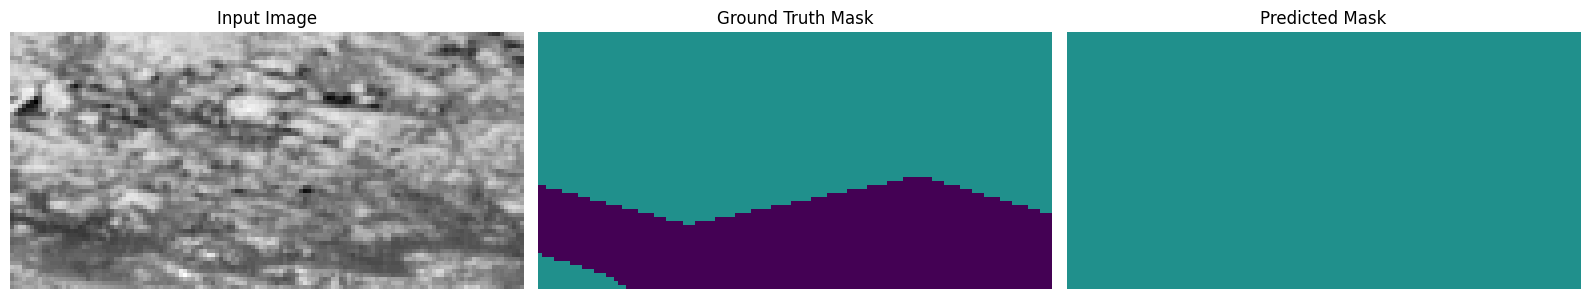

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 552ms/step - accuracy: 0.6774 - loss: 0.3602 - mean_iou: 0.5054 - val_accuracy: 0.6857 - val_loss: 0.3730 - val_mean_iou: 0.4880
Epoch 67/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 545ms/step - accuracy: 0.6785 - loss: 0.3502 - mean_iou: 0.5035 - val_accuracy: 0.6742 - val_loss: 0.3680 - val_mean_iou: 0.4767
Epoch 68/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 545ms/step - accuracy: 0.6753 - loss: 0.3607 - mean_iou: 0.4977 - val_accuracy: 0.6399 - val_loss: 0.4495 - val_mean_iou: 0.5527
Epoch 69/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step - accuracy: 0.6794 - loss: 0.3475 - mean_iou: 0.5377 - val_accuracy: 0.6714 - val_loss: 0.3917 - val_mean_iou: 0.5914
Epoch 70/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.6732 - loss: 0.3616 - mean_iou: 0.5147 - val_accuracy: 0.6719 - val_loss: 0.3890 - val_mean_iou: 0.5946
Epoch 71/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6784 - loss: 0.3612 - mean_iou: 0.5024

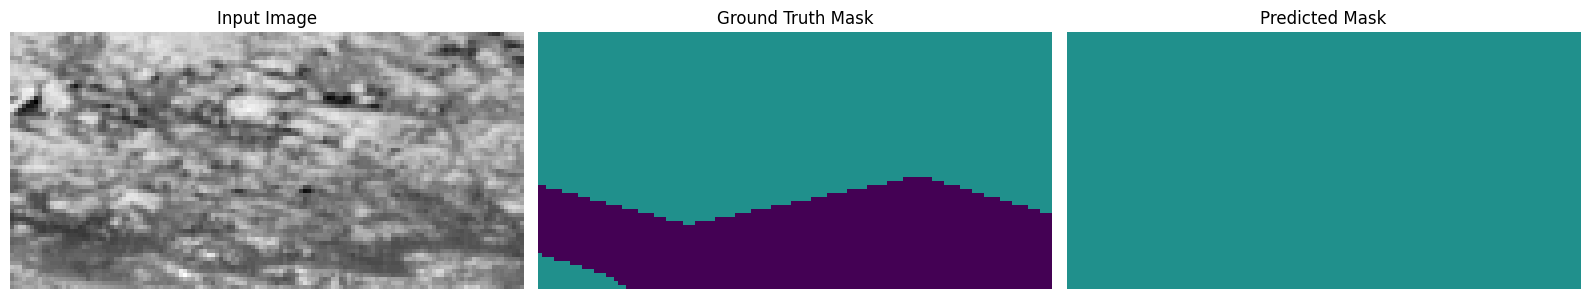

35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 549ms/step - accuracy: 0.6785 - loss: 0.3613 - mean_iou: 0.5021 - val_accuracy: 0.6774 - val_loss: 0.3724 - val_mean_iou: 0.5968
Epoch 72/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.6775 - loss: 0.3475 - mean_iou: 0.5309 - val_accuracy: 0.6796 - val_loss: 0.3824 - val_mean_iou: 0.6014
Epoch 73/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.6728 - loss: 0.3577 - mean_iou: 0.5560 - val_accuracy: 0.6742 - val_loss: 0.3696 - val_mean_iou: 0.5910
Epoch 74/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6776 - loss: 0.3469 - mean_iou: 0.5494 - val_accuracy: 0.6596 - val_loss: 0.3913 - val_mean_iou: 0.5680
Epoch 75/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 541ms/step - accuracy: 0.6760 - loss: 0.3543 - mean_iou: 0.6201 - val_accuracy: 0.5295 - val_loss: 0.7571 - val_mean_iou: 0.4318
Epoch 76/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.6801 - loss: 0.3461 - mean_iou: 0.5266

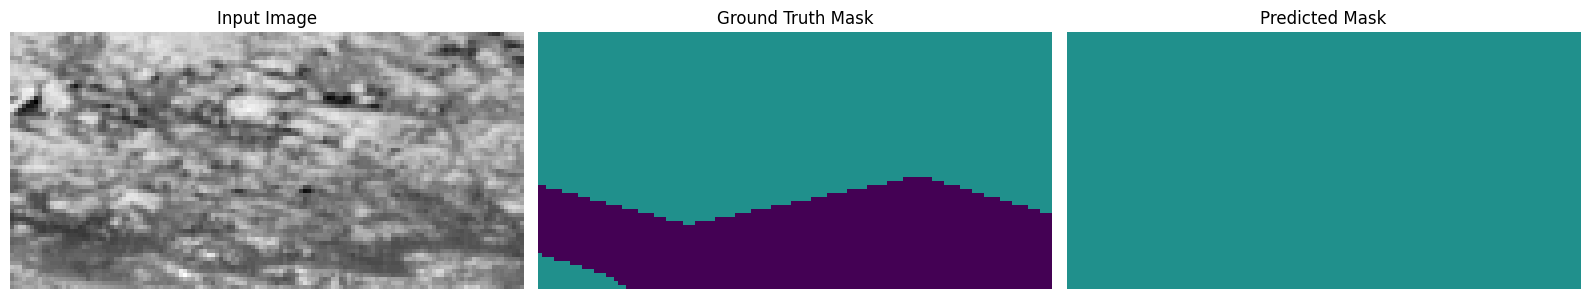

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 562ms/step - accuracy: 0.6803 - loss: 0.3462 - mean_iou: 0.5257 - val_accuracy: 0.5212 - val_loss: 0.7753 - val_mean_iou: 0.4254
Epoch 77/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 546ms/step - accuracy: 0.6772 - loss: 0.3443 - mean_iou: 0.5559 - val_accuracy: 0.6691 - val_loss: 0.3776 - val_mean_iou: 0.5886
Epoch 78/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 547ms/step - accuracy: 0.6795 - loss: 0.3432 - mean_iou: 0.5463 - val_accuracy: 0.6889 - val_loss: 0.3310 - val_mean_iou: 0.6198
Epoch 79/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.6843 - loss: 0.3307 - mean_iou: 0.5350 - val_accuracy: 0.6755 - val_loss: 0.3625 - val_mean_iou: 0.5952
Epoch 80/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 540ms/step - accuracy: 0.6860 - loss: 0.3421 - mean_iou: 0.5772 - val_accuracy: 0.6731 - val_loss: 0.3772 - val_mean_iou: 0.5947
Epoch 81/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6808 - loss: 0.3463 - mean_iou: 0.6247

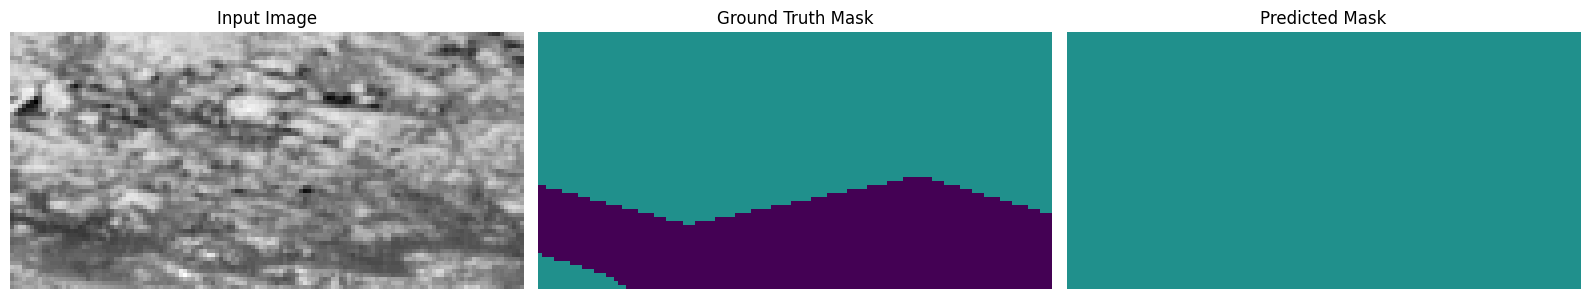

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 556ms/step - accuracy: 0.6809 - loss: 0.3465 - mean_iou: 0.6246 - val_accuracy: 0.6865 - val_loss: 0.3496 - val_mean_iou: 0.6131
Epoch 82/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step - accuracy: 0.6790 - loss: 0.3425 - mean_iou: 0.5373 - val_accuracy: 0.6669 - val_loss: 0.3800 - val_mean_iou: 0.5803
Epoch 83/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.6781 - loss: 0.3460 - mean_iou: 0.6254 - val_accuracy: 0.6751 - val_loss: 0.3619 - val_mean_iou: 0.5938
Epoch 84/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.6820 - loss: 0.3475 - mean_iou: 0.5874 - val_accuracy: 0.6646 - val_loss: 0.3973 - val_mean_iou: 0.5809
Epoch 85/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6794 - loss: 0.3373 - mean_iou: 0.6326 - val_accuracy: 0.6196 - val_loss: 0.4988 - val_mean_iou: 0.5323
Epoch 86/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6881 - loss: 0.3343 - mean_iou: 0.5502

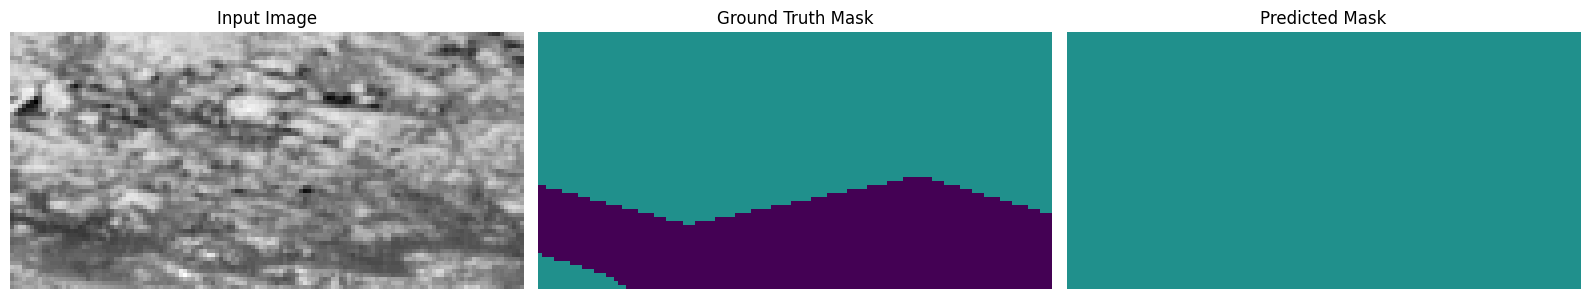

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 559ms/step - accuracy: 0.6882 - loss: 0.3345 - mean_iou: 0.5490 - val_accuracy: 0.6726 - val_loss: 0.3841 - val_mean_iou: 0.5921
Epoch 87/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 546ms/step - accuracy: 0.6843 - loss: 0.3426 - mean_iou: 0.5899 - val_accuracy: 0.6684 - val_loss: 0.3864 - val_mean_iou: 0.5838
Epoch 88/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 550ms/step - accuracy: 0.6807 - loss: 0.3500 - mean_iou: 0.6345 - val_accuracy: 0.6678 - val_loss: 0.3931 - val_mean_iou: 0.5887
Epoch 89/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.6827 - loss: 0.3385 - mean_iou: 0.5051 - val_accuracy: 0.6796 - val_loss: 0.3499 - val_mean_iou: 0.6011
Epoch 90/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6885 - loss: 0.3375 - mean_iou: 0.6300 - val_accuracy: 0.6673 - val_loss: 0.3836 - val_mean_iou: 0.5819
Epoch 91/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.6934 - loss: 0.3308 - mean_iou: 0.5623

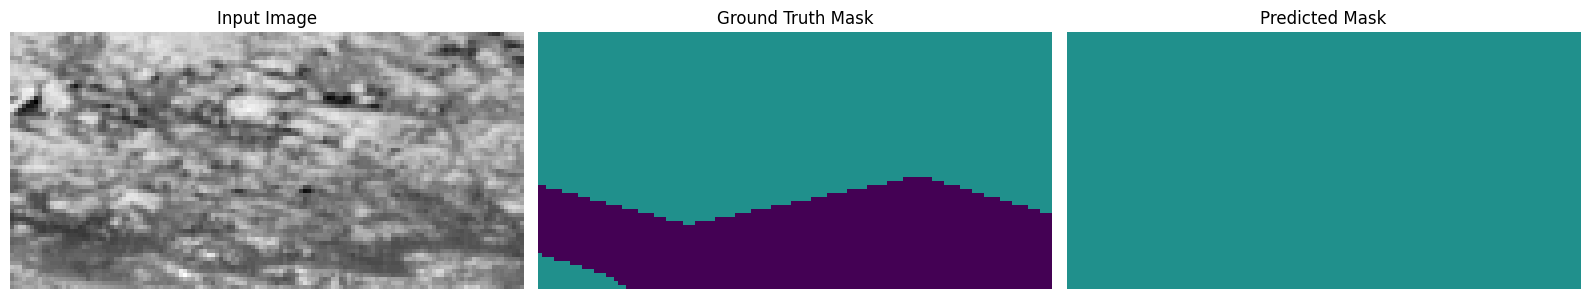

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.6935 - loss: 0.3308 - mean_iou: 0.5608 - val_accuracy: 0.6704 - val_loss: 0.4074 - val_mean_iou: 0.5855
Epoch 92/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 545ms/step - accuracy: 0.6863 - loss: 0.3383 - mean_iou: 0.5689 - val_accuracy: 0.6739 - val_loss: 0.3945 - val_mean_iou: 0.5915
Epoch 93/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 541ms/step - accuracy: 0.6872 - loss: 0.3331 - mean_iou: 0.6410 - val_accuracy: 0.6917 - val_loss: 0.3252 - val_mean_iou: 0.6260
Epoch 94/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6889 - loss: 0.3220 - mean_iou: 0.5743 - val_accuracy: 0.6889 - val_loss: 0.3340 - val_mean_iou: 0.6171
Epoch 95/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.6884 - loss: 0.3292 - mean_iou: 0.6523 - val_accuracy: 0.6858 - val_loss: 0.3381 - val_mean_iou: 0.6122
Epoch 96/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.6902 - loss: 0.3222 - mean_iou: 0.6486

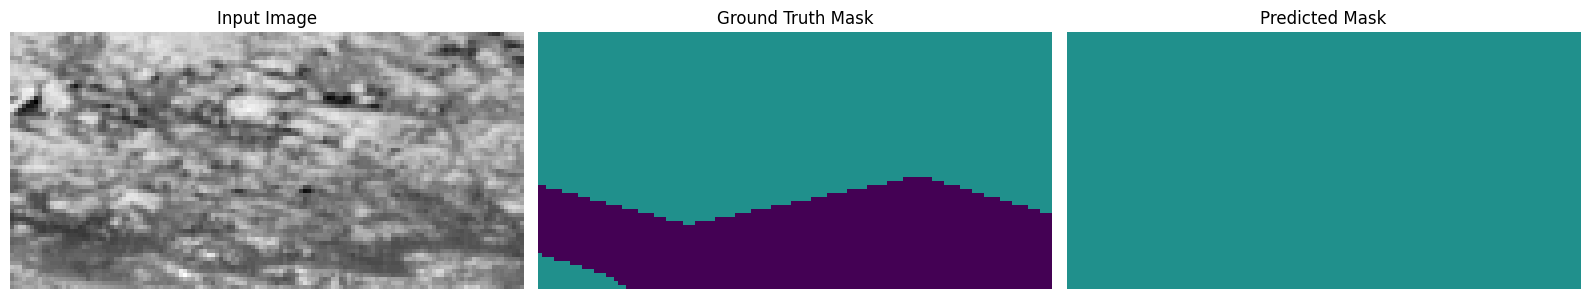

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 553ms/step - accuracy: 0.6905 - loss: 0.3222 - mean_iou: 0.6485 - val_accuracy: 0.6782 - val_loss: 0.3431 - val_mean_iou: 0.5998
Epoch 97/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 541ms/step - accuracy: 0.6879 - loss: 0.3279 - mean_iou: 0.5623 - val_accuracy: 0.6717 - val_loss: 0.3867 - val_mean_iou: 0.5950
Epoch 98/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.6842 - loss: 0.3317 - mean_iou: 0.5439 - val_accuracy: 0.6766 - val_loss: 0.3595 - val_mean_iou: 0.6003
Epoch 99/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 549ms/step - accuracy: 0.6958 - loss: 0.3204 - mean_iou: 0.6600 - val_accuracy: 0.6805 - val_loss: 0.3667 - val_mean_iou: 0.6016
Epoch 100/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.6936 - loss: 0.3226 - mean_iou: 0.6009 - val_accuracy: 0.6903 - val_loss: 0.3292 - val_mean_iou: 0.6228
Epoch 101/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6856 - loss: 0.3268 - mean_iou: 0.6490

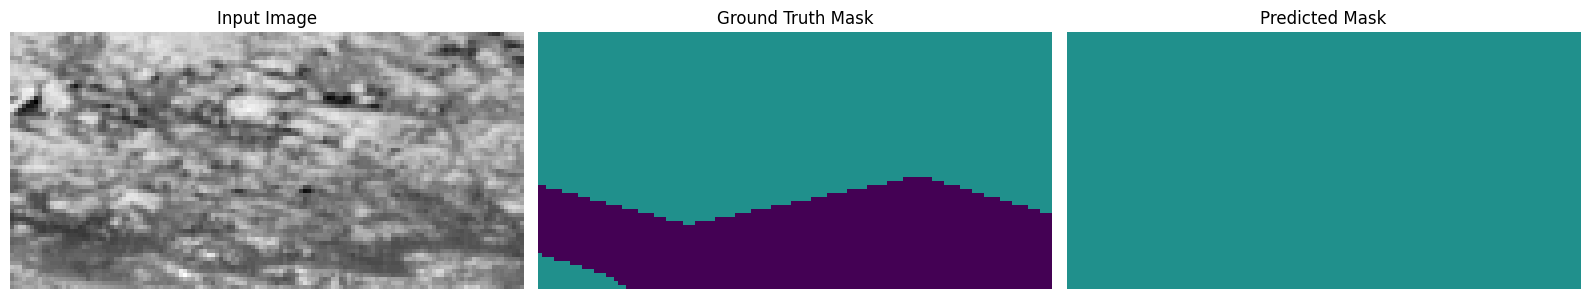

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 556ms/step - accuracy: 0.6858 - loss: 0.3269 - mean_iou: 0.6488 - val_accuracy: 0.6404 - val_loss: 0.4800 - val_mean_iou: 0.5562
Epoch 102/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.6895 - loss: 0.3238 - mean_iou: 0.5185 - val_accuracy: 0.6879 - val_loss: 0.3344 - val_mean_iou: 0.6166
Epoch 103/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 549ms/step - accuracy: 0.6860 - loss: 0.3248 - mean_iou: 0.5580 - val_accuracy: 0.6680 - val_loss: 0.3904 - val_mean_iou: 0.5865
Epoch 104/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.6917 - loss: 0.3203 - mean_iou: 0.5739 - val_accuracy: 0.6765 - val_loss: 0.3736 - val_mean_iou: 0.5980
Epoch 105/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.6920 - loss: 0.3241 - mean_iou: 0.5622 - val_accuracy: 0.6702 - val_loss: 0.3851 - val_mean_iou: 0.5853
Epoch 106/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.6892 - loss: 0.3238 - mean_iou: 0.6566

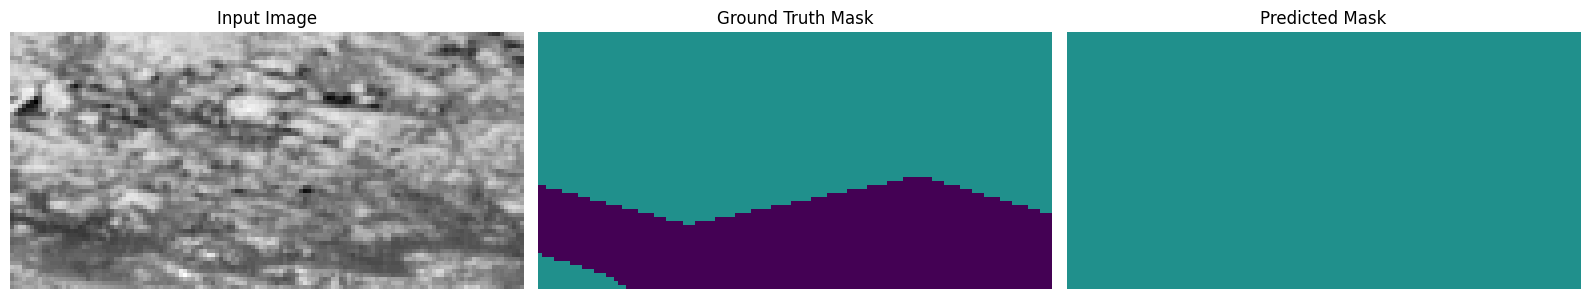

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 554ms/step - accuracy: 0.6894 - loss: 0.3238 - mean_iou: 0.6565 - val_accuracy: 0.6879 - val_loss: 0.3390 - val_mean_iou: 0.6154
Epoch 107/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.6891 - loss: 0.3214 - mean_iou: 0.5560 - val_accuracy: 0.6883 - val_loss: 0.3386 - val_mean_iou: 0.6182
Epoch 108/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 549ms/step - accuracy: 0.6900 - loss: 0.3225 - mean_iou: 0.6632 - val_accuracy: 0.6730 - val_loss: 0.3814 - val_mean_iou: 0.5935
Epoch 109/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6828 - loss: 0.3302 - mean_iou: 0.6231 - val_accuracy: 0.6912 - val_loss: 0.3283 - val_mean_iou: 0.6208
Epoch 110/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6922 - loss: 0.3163 - mean_iou: 0.5888 - val_accuracy: 0.6752 - val_loss: 0.3906 - val_mean_iou: 0.6065
Epoch 111/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6888 - loss: 0.3190 - mean_iou: 0.5410

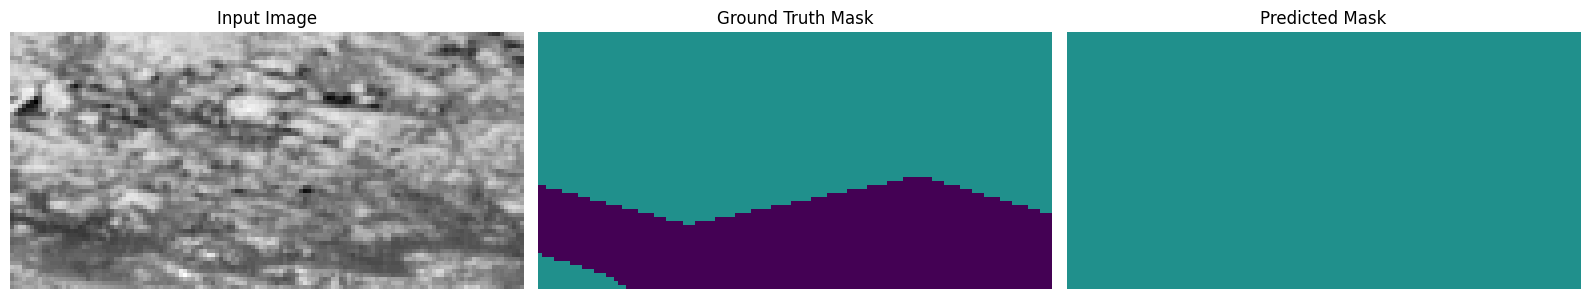

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 552ms/step - accuracy: 0.6890 - loss: 0.3190 - mean_iou: 0.5406 - val_accuracy: 0.6841 - val_loss: 0.3464 - val_mean_iou: 0.6120
Epoch 112/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 553ms/step - accuracy: 0.6963 - loss: 0.3187 - mean_iou: 0.6528 - val_accuracy: 0.6950 - val_loss: 0.3284 - val_mean_iou: 0.6282
Epoch 113/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.7036 - loss: 0.3029 - mean_iou: 0.5824 - val_accuracy: 0.6904 - val_loss: 0.3464 - val_mean_iou: 0.6234
Epoch 114/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step - accuracy: 0.6958 - loss: 0.3116 - mean_iou: 0.6624 - val_accuracy: 0.6767 - val_loss: 0.3647 - val_mean_iou: 0.6043
Epoch 115/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.6992 - loss: 0.3026 - mean_iou: 0.5828 - val_accuracy: 0.6729 - val_loss: 0.3759 - val_mean_iou: 0.5969
Epoch 116/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.6877 - loss: 0.3175 - mean_iou: 0.5383

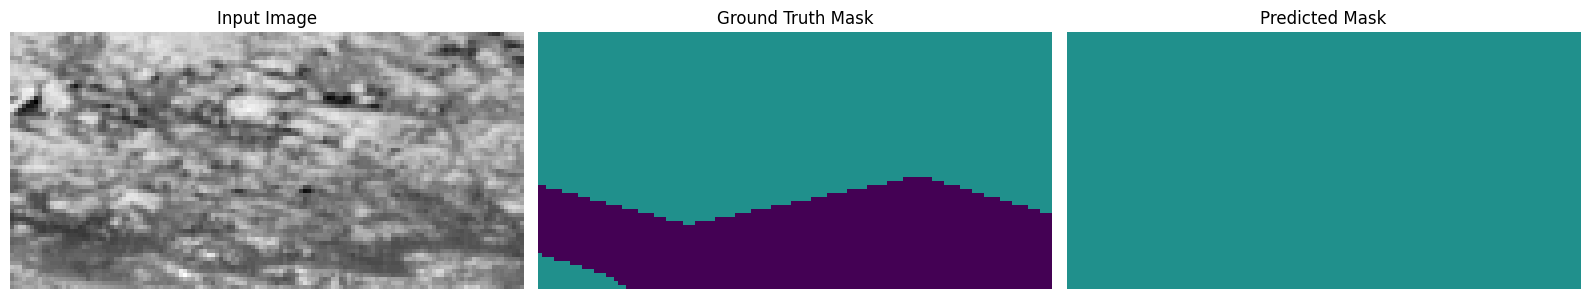

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 556ms/step - accuracy: 0.6881 - loss: 0.3175 - mean_iou: 0.5378 - val_accuracy: 0.6865 - val_loss: 0.3460 - val_mean_iou: 0.6138
Epoch 117/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 545ms/step - accuracy: 0.6951 - loss: 0.3068 - mean_iou: 0.6127 - val_accuracy: 0.6866 - val_loss: 0.3451 - val_mean_iou: 0.6154
Epoch 118/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.6941 - loss: 0.3155 - mean_iou: 0.5362 - val_accuracy: 0.6872 - val_loss: 0.3451 - val_mean_iou: 0.6148
Epoch 119/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6904 - loss: 0.3171 - mean_iou: 0.6476 - val_accuracy: 0.6846 - val_loss: 0.3499 - val_mean_iou: 0.6120
Epoch 120/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.6980 - loss: 0.3035 - mean_iou: 0.6199 - val_accuracy: 0.6782 - val_loss: 0.3853 - val_mean_iou: 0.6089
Epoch 121/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6813 - loss: 0.3298 - mean_iou: 0.5616

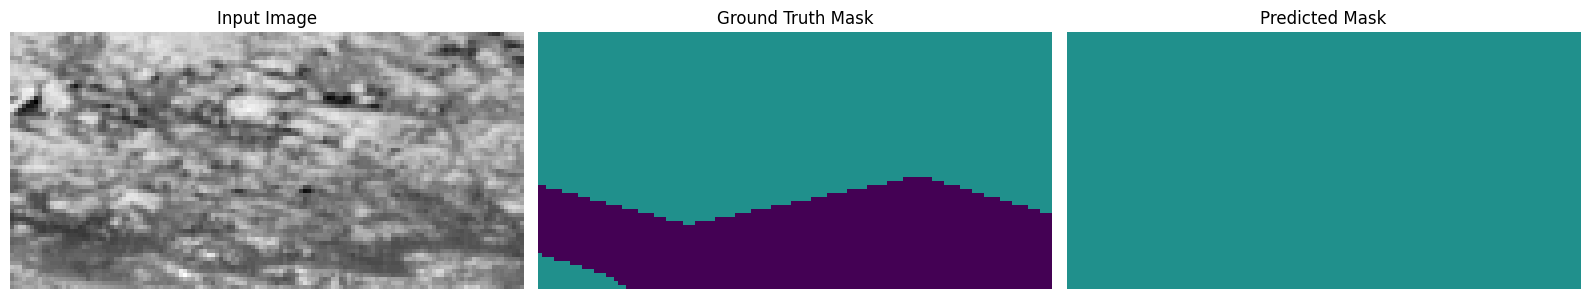

35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 558ms/step - accuracy: 0.6818 - loss: 0.3295 - mean_iou: 0.5605 - val_accuracy: 0.6792 - val_loss: 0.3542 - val_mean_iou: 0.6036
Epoch 122/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6932 - loss: 0.3096 - mean_iou: 0.6358 - val_accuracy: 0.6798 - val_loss: 0.3569 - val_mean_iou: 0.6025
Epoch 123/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 542ms/step - accuracy: 0.6924 - loss: 0.3067 - mean_iou: 0.6671 - val_accuracy: 0.6851 - val_loss: 0.3432 - val_mean_iou: 0.6115
Epoch 124/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.6905 - loss: 0.3310 - mean_iou: 0.6637 - val_accuracy: 0.6612 - val_loss: 0.4139 - val_mean_iou: 0.5757
Epoch 125/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step - accuracy: 0.6908 - loss: 0.3192 - mean_iou: 0.6825 - val_accuracy: 0.6791 - val_loss: 0.3707 - val_mean_iou: 0.6069
Epoch 126/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6990 - loss: 0.3075 - mean_iou: 0.5965

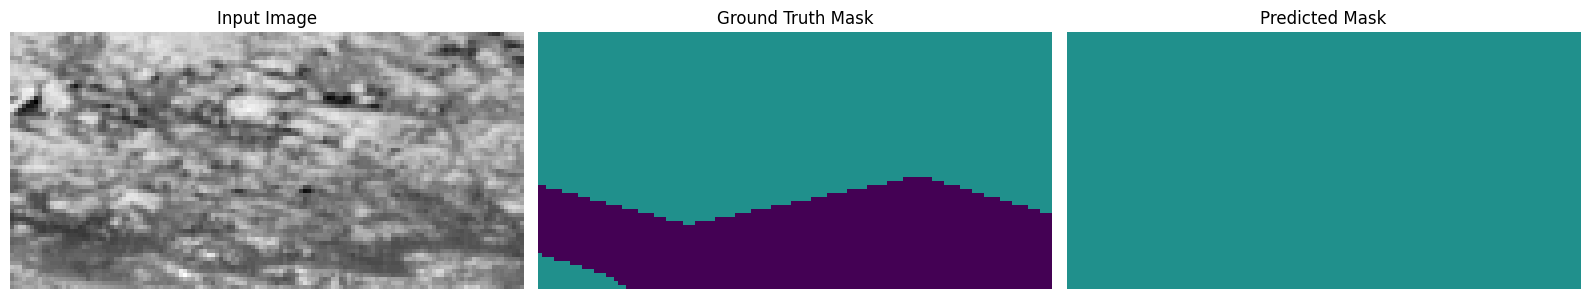

35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 557ms/step - accuracy: 0.6992 - loss: 0.3074 - mean_iou: 0.5949 - val_accuracy: 0.6822 - val_loss: 0.3643 - val_mean_iou: 0.6139
Epoch 127/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 544ms/step - accuracy: 0.7002 - loss: 0.2968 - mean_iou: 0.6834 - val_accuracy: 0.6976 - val_loss: 0.3315 - val_mean_iou: 0.6341
Epoch 128/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.6957 - loss: 0.3075 - mean_iou: 0.6309 - val_accuracy: 0.6891 - val_loss: 0.3356 - val_mean_iou: 0.6177
Epoch 129/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.6995 - loss: 0.3003 - mean_iou: 0.5441 - val_accuracy: 0.6880 - val_loss: 0.3466 - val_mean_iou: 0.6288
Epoch 130/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - accuracy: 0.6954 - loss: 0.3069 - mean_iou: 0.6706 - val_accuracy: 0.6837 - val_loss: 0.3529 - val_mean_iou: 0.6141
Epoch 131/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.6965 - loss: 0.2989 - mean_iou: 0.6778

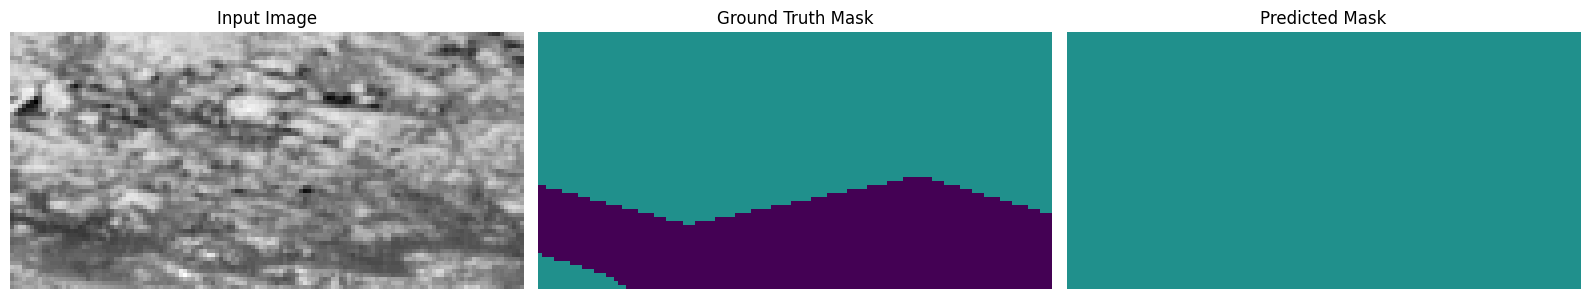

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 554ms/step - accuracy: 0.6967 - loss: 0.2991 - mean_iou: 0.6775 - val_accuracy: 0.6799 - val_loss: 0.3705 - val_mean_iou: 0.6187
Epoch 132/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 549ms/step - accuracy: 0.6967 - loss: 0.3080 - mean_iou: 0.6700 - val_accuracy: 0.6956 - val_loss: 0.3272 - val_mean_iou: 0.6339
Epoch 133/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6955 - loss: 0.3036 - mean_iou: 0.6833 - val_accuracy: 0.6595 - val_loss: 0.4207 - val_mean_iou: 0.5960
Epoch 134/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 560ms/step - accuracy: 0.7001 - loss: 0.2998 - mean_iou: 0.6505 - val_accuracy: 0.6951 - val_loss: 0.3390 - val_mean_iou: 0.6285
Epoch 135/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.7010 - loss: 0.2985 - mean_iou: 0.6870 - val_accuracy: 0.6913 - val_loss: 0.3322 - val_mean_iou: 0.6224
Epoch 136/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6953 - loss: 0.2963 - mean_iou: 0.6795

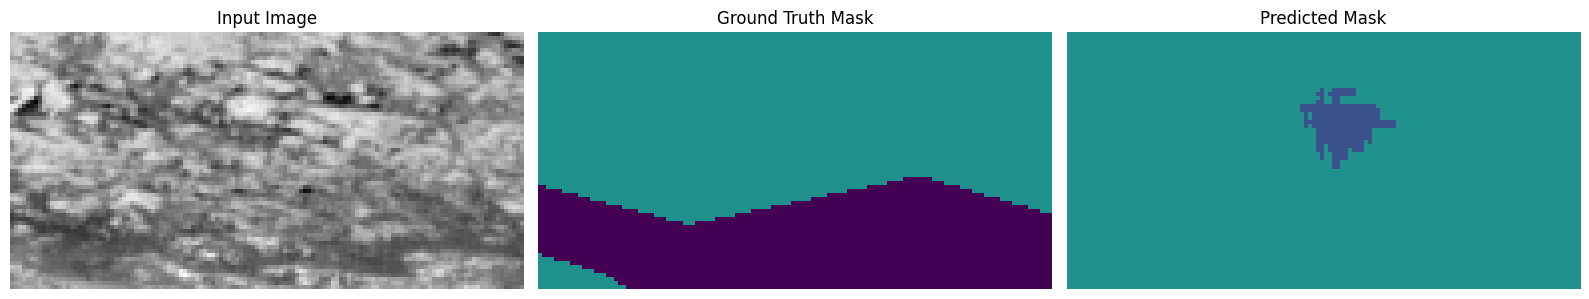

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 553ms/step - accuracy: 0.6955 - loss: 0.2966 - mean_iou: 0.6755 - val_accuracy: 0.6855 - val_loss: 0.3667 - val_mean_iou: 0.4920
Epoch 137/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.7016 - loss: 0.2957 - mean_iou: 0.6875 - val_accuracy: 0.6956 - val_loss: 0.3272 - val_mean_iou: 0.6333
Epoch 138/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.6999 - loss: 0.2983 - mean_iou: 0.6924 - val_accuracy: 0.6952 - val_loss: 0.3329 - val_mean_iou: 0.6307
Epoch 139/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.7027 - loss: 0.2895 - mean_iou: 0.6923 - val_accuracy: 0.6927 - val_loss: 0.3318 - val_mean_iou: 0.6243
Epoch 140/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 540ms/step - accuracy: 0.7098 - loss: 0.2843 - mean_iou: 0.7257 - val_accuracy: 0.6972 - val_loss: 0.3203 - val_mean_iou: 0.6356
Epoch 141/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7042 - loss: 0.2956 - mean_iou: 0.7046

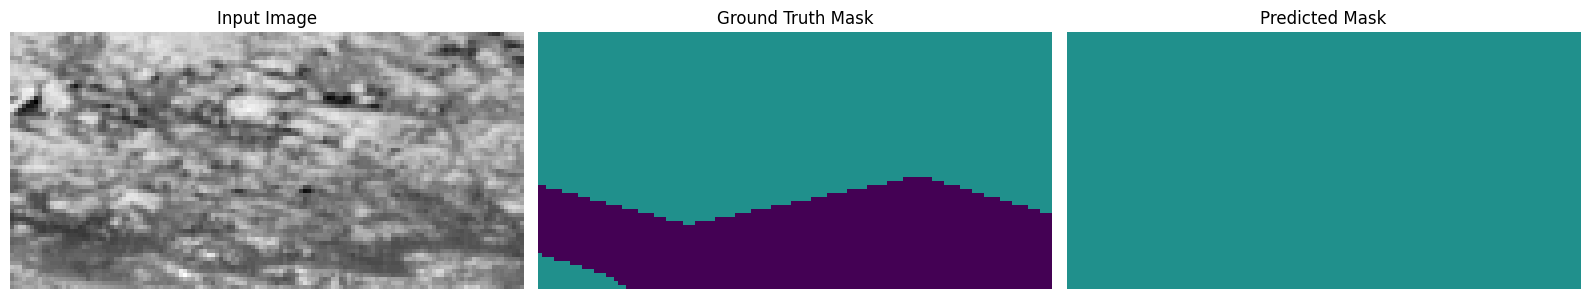

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 557ms/step - accuracy: 0.7044 - loss: 0.2957 - mean_iou: 0.7045 - val_accuracy: 0.6955 - val_loss: 0.3224 - val_mean_iou: 0.6286
Epoch 142/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.6991 - loss: 0.3025 - mean_iou: 0.6603 - val_accuracy: 0.6314 - val_loss: 0.4955 - val_mean_iou: 0.5395
Epoch 143/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.7042 - loss: 0.2906 - mean_iou: 0.6724 - val_accuracy: 0.6926 - val_loss: 0.3227 - val_mean_iou: 0.6344
Epoch 144/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - accuracy: 0.7039 - loss: 0.2890 - mean_iou: 0.5916 - val_accuracy: 0.7038 - val_loss: 0.3164 - val_mean_iou: 0.6595
Epoch 145/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 552ms/step - accuracy: 0.7024 - loss: 0.2876 - mean_iou: 0.5565 - val_accuracy: 0.6880 - val_loss: 0.3420 - val_mean_iou: 0.6169
Epoch 146/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.7075 - loss: 0.2911 - mean_iou: 0.5723

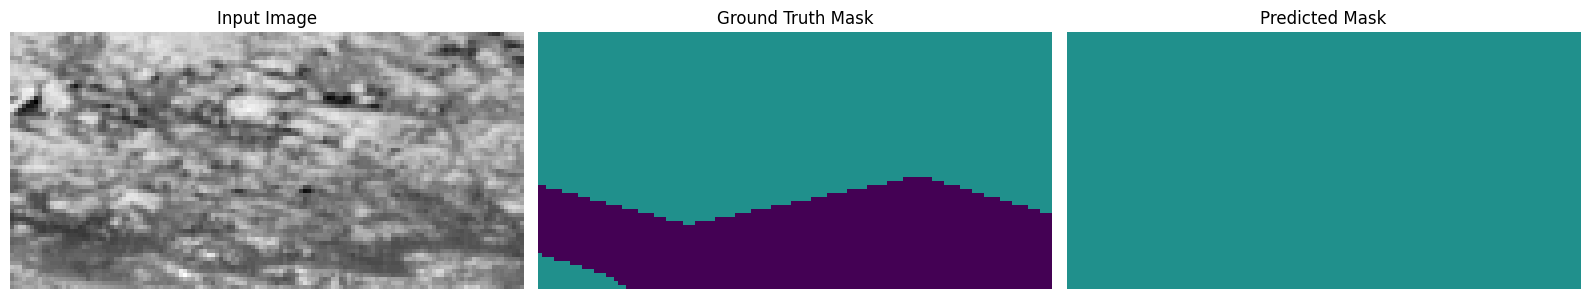

35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 549ms/step - accuracy: 0.7076 - loss: 0.2911 - mean_iou: 0.5721 - val_accuracy: 0.6960 - val_loss: 0.3309 - val_mean_iou: 0.6318
Epoch 147/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - accuracy: 0.7028 - loss: 0.2895 - mean_iou: 0.6346 - val_accuracy: 0.6719 - val_loss: 0.3786 - val_mean_iou: 0.6023
Epoch 148/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 540ms/step - accuracy: 0.6973 - loss: 0.2975 - mean_iou: 0.6893 - val_accuracy: 0.7008 - val_loss: 0.3375 - val_mean_iou: 0.6378
Epoch 149/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.7030 - loss: 0.2907 - mean_iou: 0.7085 - val_accuracy: 0.6864 - val_loss: 0.3477 - val_mean_iou: 0.6171
Epoch 150/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.7045 - loss: 0.2773 - mean_iou: 0.6253 - val_accuracy: 0.6863 - val_loss: 0.3529 - val_mean_iou: 0.6229
Epoch 151/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.7022 - loss: 0.2927 - mean_iou: 0.7199

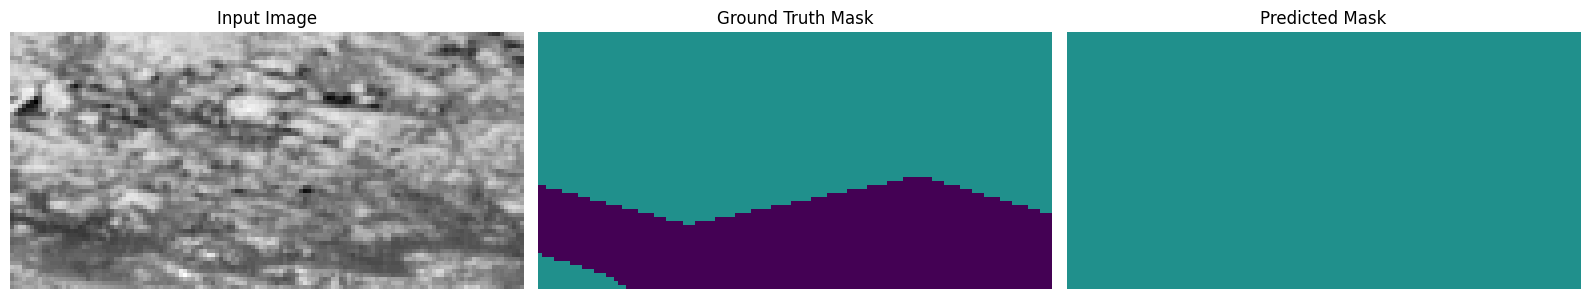

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 559ms/step - accuracy: 0.7024 - loss: 0.2929 - mean_iou: 0.7193 - val_accuracy: 0.6843 - val_loss: 0.3475 - val_mean_iou: 0.6402
Epoch 152/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.6975 - loss: 0.3020 - mean_iou: 0.6215 - val_accuracy: 0.5967 - val_loss: 0.5683 - val_mean_iou: 0.5126
Epoch 153/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step - accuracy: 0.7038 - loss: 0.2900 - mean_iou: 0.7108 - val_accuracy: 0.6797 - val_loss: 0.3480 - val_mean_iou: 0.6089
Epoch 154/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 544ms/step - accuracy: 0.7044 - loss: 0.2862 - mean_iou: 0.6213 - val_accuracy: 0.5670 - val_loss: 0.6640 - val_mean_iou: 0.4721
Epoch 155/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 541ms/step - accuracy: 0.7015 - loss: 0.2936 - mean_iou: 0.6815 - val_accuracy: 0.6932 - val_loss: 0.3362 - val_mean_iou: 0.6358
Epoch 156/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.7045 - loss: 0.2820 - mean_iou: 0.7022

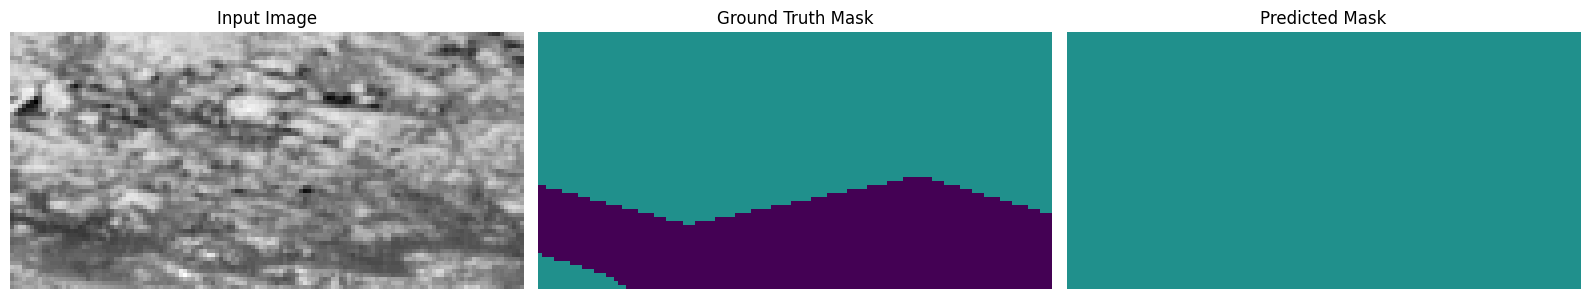

35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 560ms/step - accuracy: 0.7048 - loss: 0.2823 - mean_iou: 0.7016 - val_accuracy: 0.6850 - val_loss: 0.3638 - val_mean_iou: 0.6146
Epoch 157/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 545ms/step - accuracy: 0.7002 - loss: 0.2905 - mean_iou: 0.7142 - val_accuracy: 0.6897 - val_loss: 0.3384 - val_mean_iou: 0.6304
Epoch 158/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.7015 - loss: 0.2840 - mean_iou: 0.5510 - val_accuracy: 0.6885 - val_loss: 0.3418 - val_mean_iou: 0.6242
Epoch 159/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step - accuracy: 0.7062 - loss: 0.2883 - mean_iou: 0.6335 - val_accuracy: 0.6984 - val_loss: 0.3179 - val_mean_iou: 0.6339
Epoch 160/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.7064 - loss: 0.2883 - mean_iou: 0.7209 - val_accuracy: 0.6976 - val_loss: 0.3128 - val_mean_iou: 0.6338
Epoch 161/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.7004 - loss: 0.2909 - mean_iou: 0.7168

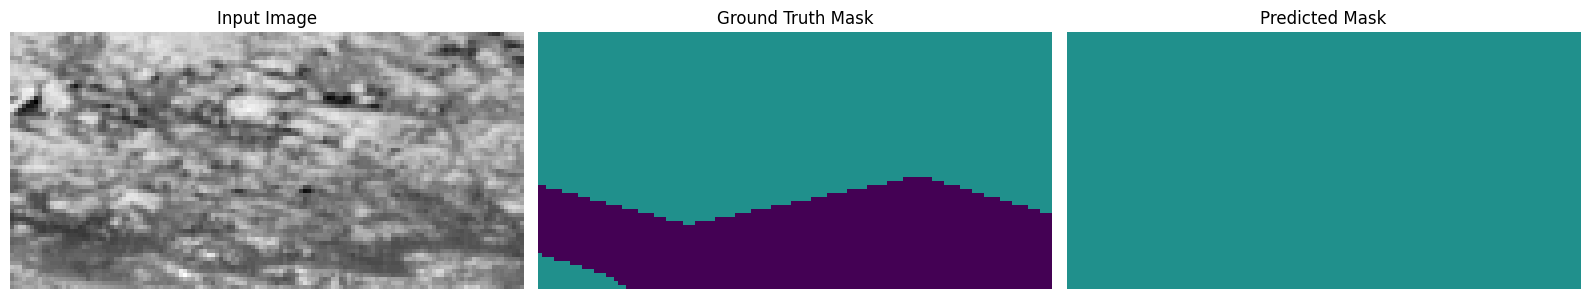

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 556ms/step - accuracy: 0.7007 - loss: 0.2908 - mean_iou: 0.7168 - val_accuracy: 0.6942 - val_loss: 0.3262 - val_mean_iou: 0.6462
Epoch 162/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.7069 - loss: 0.2809 - mean_iou: 0.6333 - val_accuracy: 0.6887 - val_loss: 0.3527 - val_mean_iou: 0.6404
Epoch 163/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.7085 - loss: 0.2814 - mean_iou: 0.6045 - val_accuracy: 0.6931 - val_loss: 0.3376 - val_mean_iou: 0.6550
Epoch 164/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 543ms/step - accuracy: 0.7046 - loss: 0.2855 - mean_iou: 0.7055 - val_accuracy: 0.6899 - val_loss: 0.3382 - val_mean_iou: 0.6465
Epoch 165/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 542ms/step - accuracy: 0.7102 - loss: 0.2830 - mean_iou: 0.5773 - val_accuracy: 0.6920 - val_loss: 0.3373 - val_mean_iou: 0.6306
Epoch 166/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.7015 - loss: 0.2935 - mean_iou: 0.5681

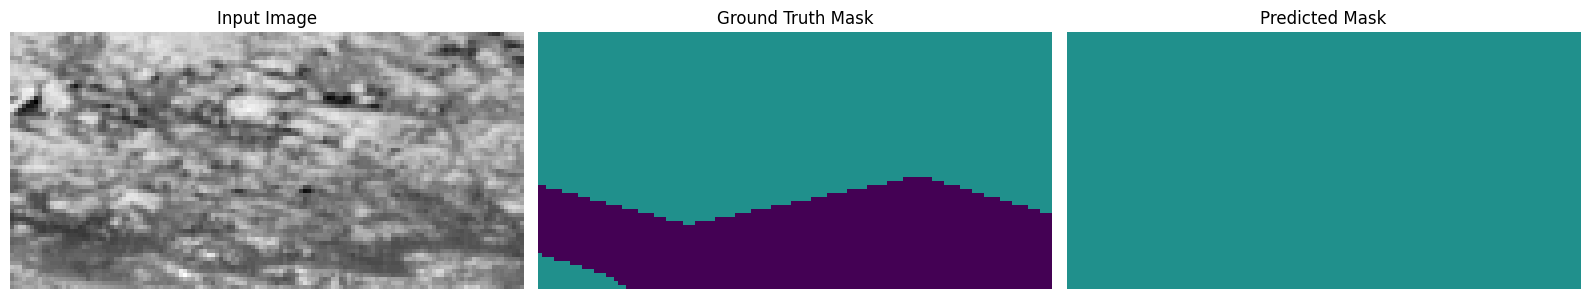

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 552ms/step - accuracy: 0.7018 - loss: 0.2934 - mean_iou: 0.5678 - val_accuracy: 0.6888 - val_loss: 0.3390 - val_mean_iou: 0.6298
Epoch 167/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.7108 - loss: 0.2706 - mean_iou: 0.7213 - val_accuracy: 0.6915 - val_loss: 0.3311 - val_mean_iou: 0.6304
Epoch 168/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 556ms/step - accuracy: 0.7120 - loss: 0.2728 - mean_iou: 0.7233 - val_accuracy: 0.6780 - val_loss: 0.3827 - val_mean_iou: 0.6067
Epoch 169/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.7040 - loss: 0.2912 - mean_iou: 0.6805 - val_accuracy: 0.6910 - val_loss: 0.3367 - val_mean_iou: 0.6261
Epoch 170/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.7051 - loss: 0.2728 - mean_iou: 0.7301 - val_accuracy: 0.6886 - val_loss: 0.3400 - val_mean_iou: 0.6305
Epoch 171/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7079 - loss: 0.2740 - mean_iou: 0.6647

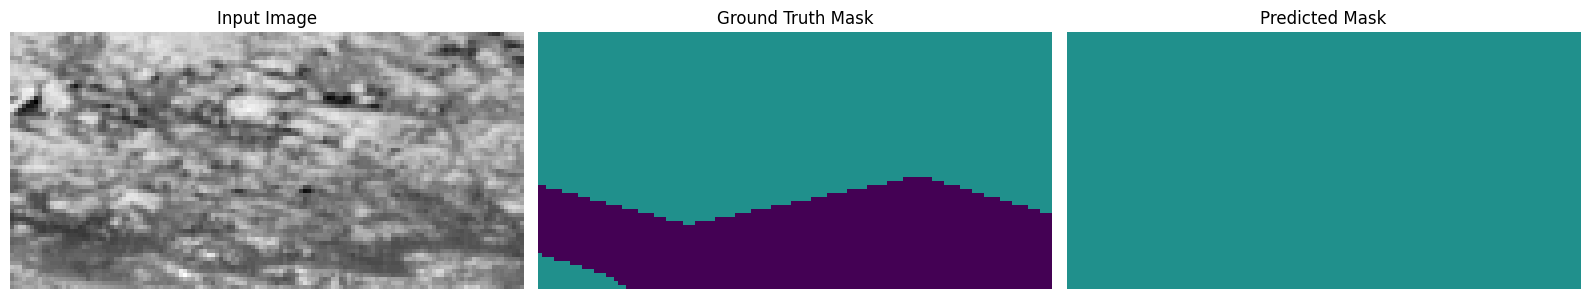

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 556ms/step - accuracy: 0.7082 - loss: 0.2740 - mean_iou: 0.6618 - val_accuracy: 0.6894 - val_loss: 0.3369 - val_mean_iou: 0.6196
Epoch 172/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.7047 - loss: 0.2914 - mean_iou: 0.6820 - val_accuracy: 0.6945 - val_loss: 0.3391 - val_mean_iou: 0.6288
Epoch 173/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step - accuracy: 0.7109 - loss: 0.2732 - mean_iou: 0.7305 - val_accuracy: 0.6944 - val_loss: 0.3350 - val_mean_iou: 0.6519
Epoch 174/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 550ms/step - accuracy: 0.7060 - loss: 0.2885 - mean_iou: 0.6473 - val_accuracy: 0.7002 - val_loss: 0.3303 - val_mean_iou: 0.6729
Epoch 175/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.7069 - loss: 0.2826 - mean_iou: 0.6892 - val_accuracy: 0.6924 - val_loss: 0.3375 - val_mean_iou: 0.6317
Epoch 176/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.7111 - loss: 0.2708 - mean_iou: 0.7364

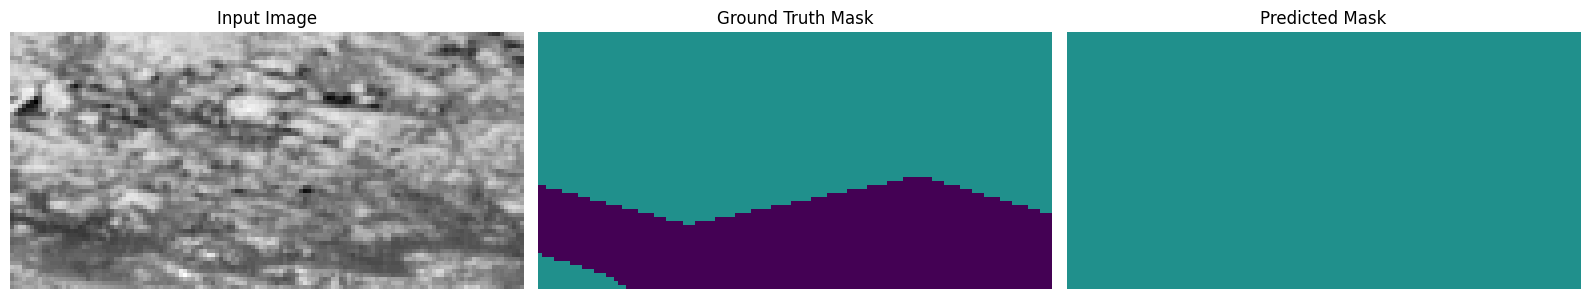

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - accuracy: 0.7114 - loss: 0.2707 - mean_iou: 0.7364 - val_accuracy: 0.7031 - val_loss: 0.3224 - val_mean_iou: 0.6429
Epoch 177/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.7157 - loss: 0.2688 - mean_iou: 0.7435 - val_accuracy: 0.6572 - val_loss: 0.4247 - val_mean_iou: 0.5935
Epoch 178/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.7044 - loss: 0.2764 - mean_iou: 0.6954 - val_accuracy: 0.6948 - val_loss: 0.3342 - val_mean_iou: 0.6451
Epoch 179/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step - accuracy: 0.7100 - loss: 0.2723 - mean_iou: 0.7217 - val_accuracy: 0.6966 - val_loss: 0.3367 - val_mean_iou: 0.6519
Epoch 180/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 547ms/step - accuracy: 0.7118 - loss: 0.2703 - mean_iou: 0.7119 - val_accuracy: 0.6915 - val_loss: 0.3384 - val_mean_iou: 0.6315
Epoch 181/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.7088 - loss: 0.2807 - mean_iou: 0.7058

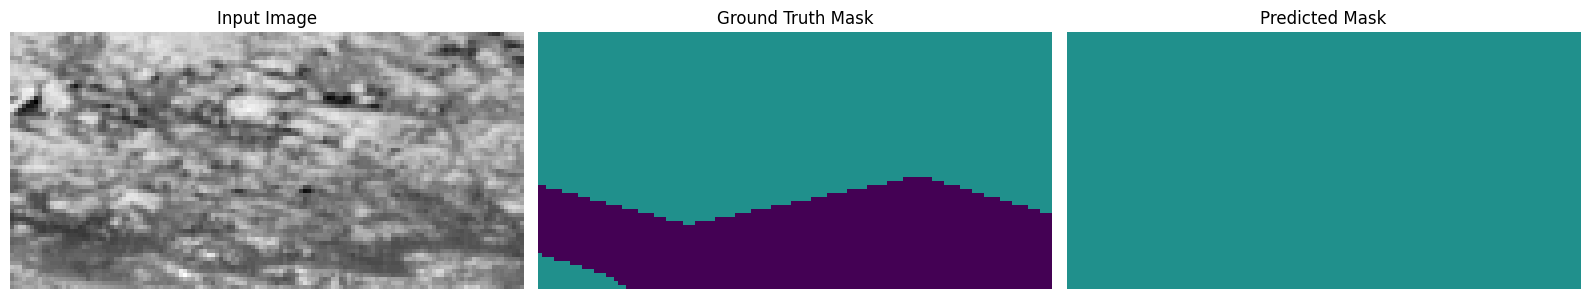

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 551ms/step - accuracy: 0.7090 - loss: 0.2807 - mean_iou: 0.7054 - val_accuracy: 0.6812 - val_loss: 0.3599 - val_mean_iou: 0.6400
Epoch 182/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 553ms/step - accuracy: 0.7102 - loss: 0.2695 - mean_iou: 0.7343 - val_accuracy: 0.7021 - val_loss: 0.3136 - val_mean_iou: 0.6415
Epoch 183/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 545ms/step - accuracy: 0.7105 - loss: 0.2741 - mean_iou: 0.7282 - val_accuracy: 0.6042 - val_loss: 0.5566 - val_mean_iou: 0.5110
Epoch 184/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 548ms/step - accuracy: 0.7109 - loss: 0.2723 - mean_iou: 0.7364 - val_accuracy: 0.6820 - val_loss: 0.3593 - val_mean_iou: 0.6105
Epoch 185/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.7190 - loss: 0.2633 - mean_iou: 0.7410 - val_accuracy: 0.6821 - val_loss: 0.3509 - val_mean_iou: 0.6423
Epoch 186/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.7086 - loss: 0.2782 - mean_iou: 0.7239

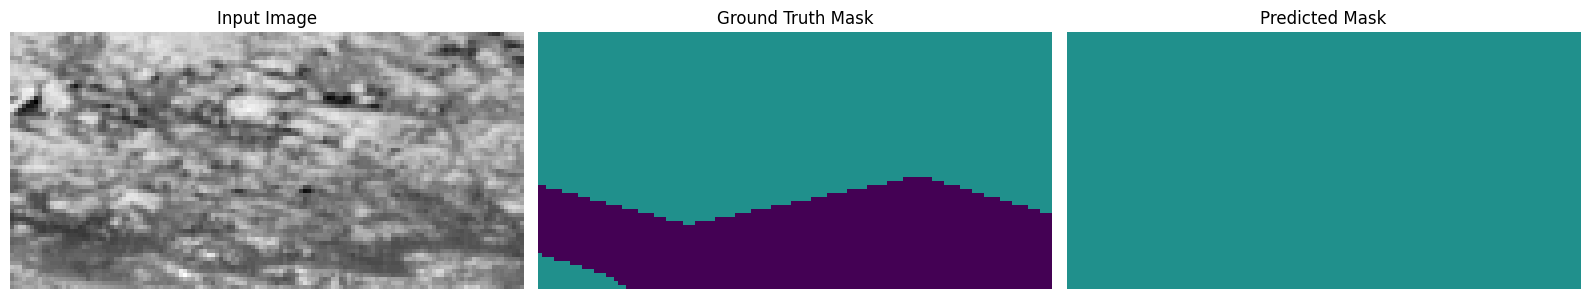

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 557ms/step - accuracy: 0.7089 - loss: 0.2781 - mean_iou: 0.7237 - val_accuracy: 0.7005 - val_loss: 0.3228 - val_mean_iou: 0.6726
Epoch 187/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.7073 - loss: 0.2790 - mean_iou: 0.7376 - val_accuracy: 0.7034 - val_loss: 0.3102 - val_mean_iou: 0.6885
Epoch 188/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.7085 - loss: 0.2794 - mean_iou: 0.7144 - val_accuracy: 0.6984 - val_loss: 0.3315 - val_mean_iou: 0.6491
Epoch 189/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.7090 - loss: 0.2809 - mean_iou: 0.6946 - val_accuracy: 0.6979 - val_loss: 0.3323 - val_mean_iou: 0.6634
Epoch 190/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.7094 - loss: 0.2661 - mean_iou: 0.7553 - val_accuracy: 0.6990 - val_loss: 0.3350 - val_mean_iou: 0.6730
Epoch 191/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7142 - loss: 0.2670 - mean_iou: 0.7331

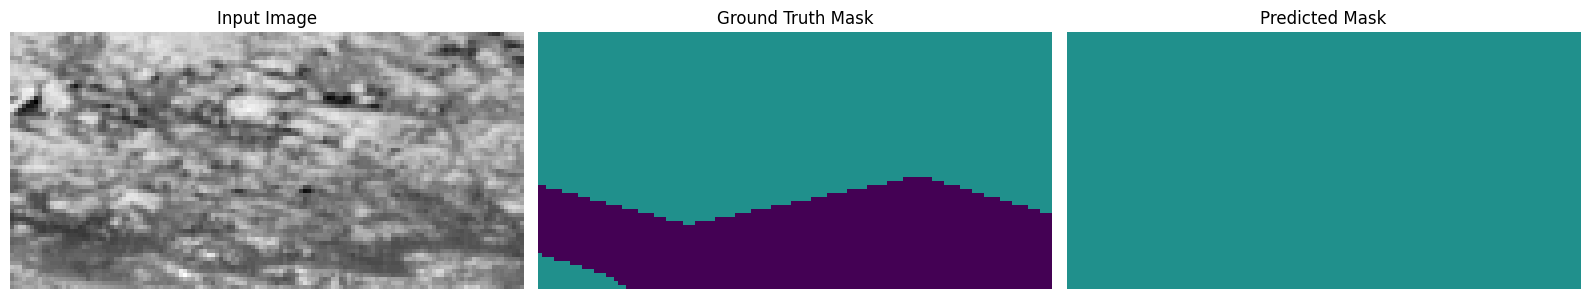

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 557ms/step - accuracy: 0.7144 - loss: 0.2670 - mean_iou: 0.7331 - val_accuracy: 0.6922 - val_loss: 0.3429 - val_mean_iou: 0.6495
Epoch 192/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.7142 - loss: 0.2643 - mean_iou: 0.7457 - val_accuracy: 0.6987 - val_loss: 0.3208 - val_mean_iou: 0.6707
Epoch 193/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.7083 - loss: 0.2706 - mean_iou: 0.7512 - val_accuracy: 0.6873 - val_loss: 0.3467 - val_mean_iou: 0.6504
Epoch 194/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step - accuracy: 0.7093 - loss: 0.2704 - mean_iou: 0.7218 - val_accuracy: 0.6872 - val_loss: 0.3395 - val_mean_iou: 0.6188
Epoch 195/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.7085 - loss: 0.2691 - mean_iou: 0.6428 - val_accuracy: 0.6902 - val_loss: 0.3379 - val_mean_iou: 0.6433
Epoch 196/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.7134 - loss: 0.2628 - mean_iou: 0.7660

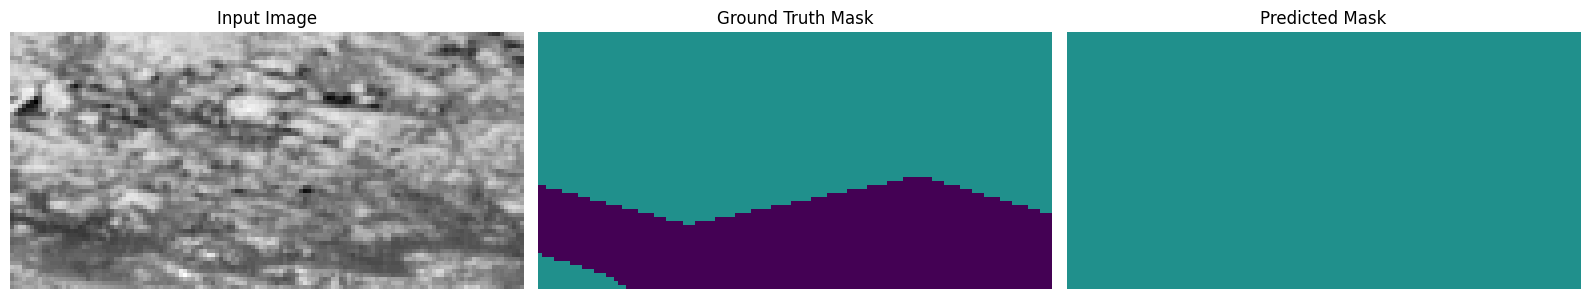

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 549ms/step - accuracy: 0.7136 - loss: 0.2628 - mean_iou: 0.7652 - val_accuracy: 0.7059 - val_loss: 0.3083 - val_mean_iou: 0.6912
Epoch 197/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - accuracy: 0.7151 - loss: 0.2699 - mean_iou: 0.7364 - val_accuracy: 0.6973 - val_loss: 0.3264 - val_mean_iou: 0.6639
Epoch 198/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 543ms/step - accuracy: 0.7134 - loss: 0.2723 - mean_iou: 0.7632 - val_accuracy: 0.6861 - val_loss: 0.3500 - val_mean_iou: 0.6652
Epoch 199/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step - accuracy: 0.7059 - loss: 0.2733 - mean_iou: 0.7356 - val_accuracy: 0.7024 - val_loss: 0.3130 - val_mean_iou: 0.6758
Epoch 200/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 543ms/step - accuracy: 0.7157 - loss: 0.2638 - mean_iou: 0.6664 - val_accuracy: 0.6990 - val_loss: 0.3186 - val_mean_iou: 0.6774
Epoch 201/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.7104 - loss: 0.2760 - mean_iou: 0.6173

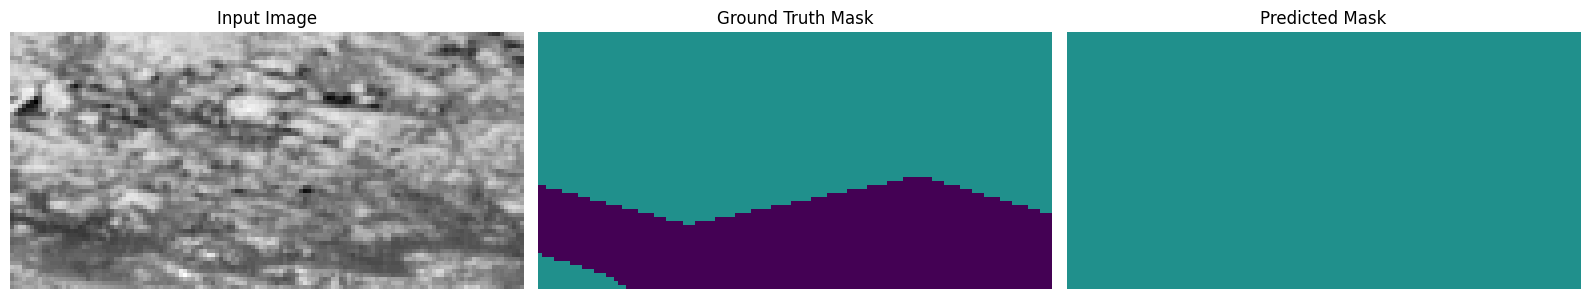

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 558ms/step - accuracy: 0.7107 - loss: 0.2758 - mean_iou: 0.6165 - val_accuracy: 0.7026 - val_loss: 0.3104 - val_mean_iou: 0.6796
Epoch 202/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.7114 - loss: 0.2683 - mean_iou: 0.7492 - val_accuracy: 0.7033 - val_loss: 0.3133 - val_mean_iou: 0.6786
Epoch 203/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.7124 - loss: 0.2732 - mean_iou: 0.7230 - val_accuracy: 0.6980 - val_loss: 0.3285 - val_mean_iou: 0.6753
Epoch 204/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step - accuracy: 0.7157 - loss: 0.2637 - mean_iou: 0.7501 - val_accuracy: 0.6989 - val_loss: 0.3243 - val_mean_iou: 0.6827
Epoch 205/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.7108 - loss: 0.2713 - mean_iou: 0.7583 - val_accuracy: 0.6995 - val_loss: 0.3257 - val_mean_iou: 0.6847
Epoch 206/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.7130 - loss: 0.2624 - mean_iou: 0.6429

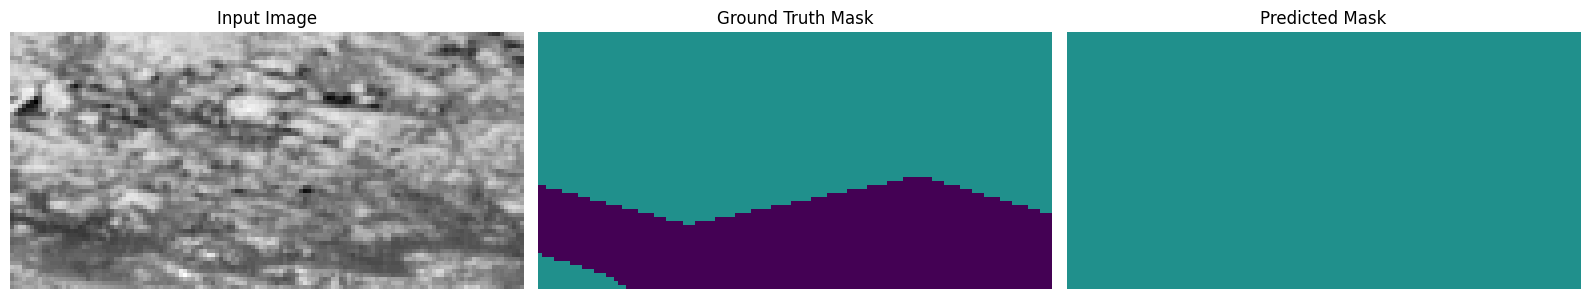

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.7133 - loss: 0.2624 - mean_iou: 0.6413 - val_accuracy: 0.6986 - val_loss: 0.3227 - val_mean_iou: 0.6861
Epoch 207/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.7123 - loss: 0.2704 - mean_iou: 0.7131 - val_accuracy: 0.6910 - val_loss: 0.3432 - val_mean_iou: 0.6611
Epoch 208/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 543ms/step - accuracy: 0.7140 - loss: 0.2746 - mean_iou: 0.6667 - val_accuracy: 0.6674 - val_loss: 0.3934 - val_mean_iou: 0.6522
Epoch 209/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 541ms/step - accuracy: 0.7116 - loss: 0.2665 - mean_iou: 0.7411 - val_accuracy: 0.6696 - val_loss: 0.3780 - val_mean_iou: 0.6258
Epoch 210/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.7155 - loss: 0.2640 - mean_iou: 0.7409 - val_accuracy: 0.6928 - val_loss: 0.3292 - val_mean_iou: 0.6739
Epoch 211/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7094 - loss: 0.2692 - mean_iou: 0.6982

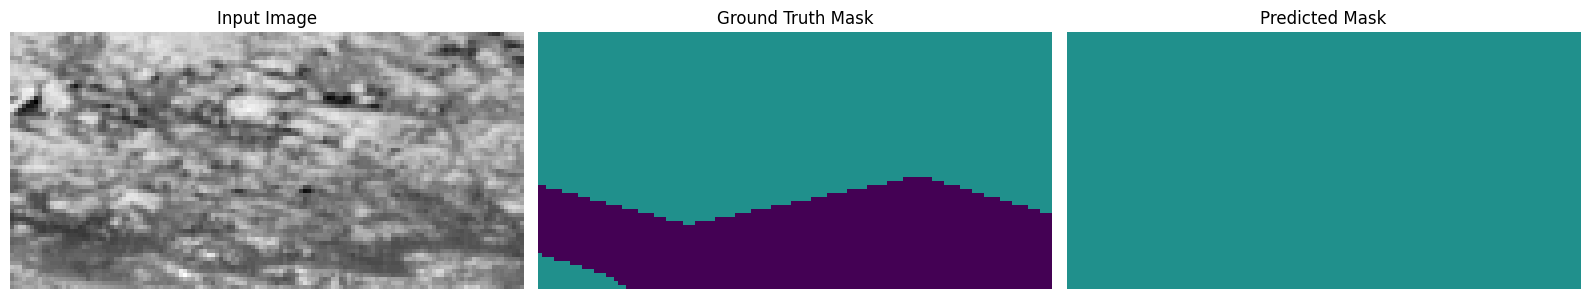

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.7097 - loss: 0.2693 - mean_iou: 0.6955 - val_accuracy: 0.6909 - val_loss: 0.3380 - val_mean_iou: 0.6767
Epoch 212/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.7170 - loss: 0.2592 - mean_iou: 0.7732 - val_accuracy: 0.6990 - val_loss: 0.3259 - val_mean_iou: 0.6761
Epoch 213/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.7099 - loss: 0.2766 - mean_iou: 0.7301 - val_accuracy: 0.6887 - val_loss: 0.3377 - val_mean_iou: 0.6491
Epoch 214/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.7178 - loss: 0.2590 - mean_iou: 0.7613 - val_accuracy: 0.6905 - val_loss: 0.3389 - val_mean_iou: 0.6640
Epoch 215/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.7164 - loss: 0.2694 - mean_iou: 0.7655 - val_accuracy: 0.6918 - val_loss: 0.3349 - val_mean_iou: 0.6646
Epoch 216/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.7142 - loss: 0.2637 - mean_iou: 0.7643

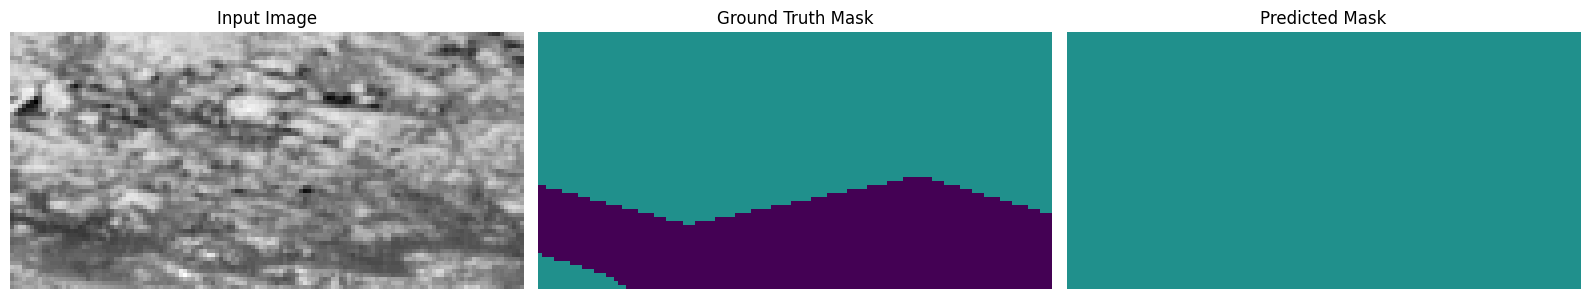

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 552ms/step - accuracy: 0.7145 - loss: 0.2637 - mean_iou: 0.7641 - val_accuracy: 0.6968 - val_loss: 0.3221 - val_mean_iou: 0.6820
Epoch 217/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 546ms/step - accuracy: 0.7175 - loss: 0.2576 - mean_iou: 0.7748 - val_accuracy: 0.6939 - val_loss: 0.3303 - val_mean_iou: 0.6579
Epoch 218/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.7131 - loss: 0.2702 - mean_iou: 0.7445 - val_accuracy: 0.7013 - val_loss: 0.3227 - val_mean_iou: 0.6858
Epoch 219/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step - accuracy: 0.7079 - loss: 0.2716 - mean_iou: 0.6549 - val_accuracy: 0.6961 - val_loss: 0.3312 - val_mean_iou: 0.6710
Epoch 220/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.7124 - loss: 0.2713 - mean_iou: 0.7334 - val_accuracy: 0.6835 - val_loss: 0.3574 - val_mean_iou: 0.6515
Epoch 221/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.7134 - loss: 0.2592 - mean_iou: 0.7479

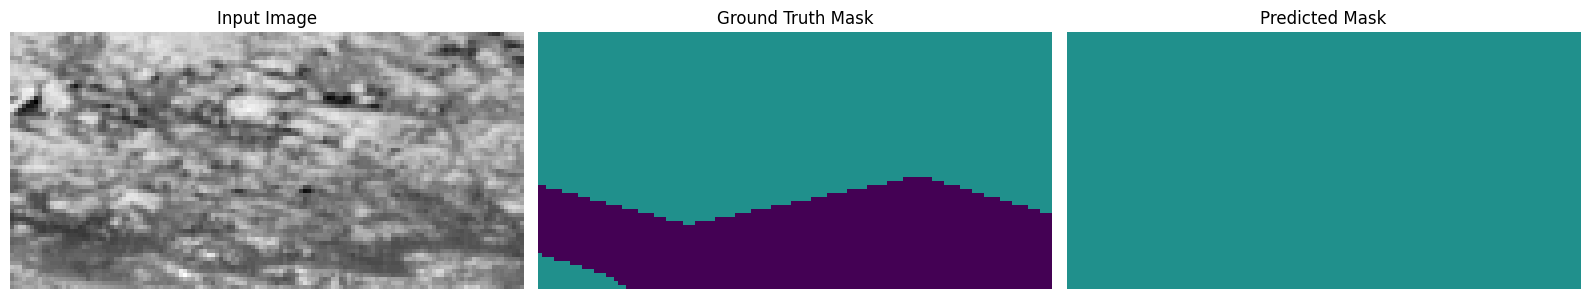

35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 578ms/step - accuracy: 0.7137 - loss: 0.2593 - mean_iou: 0.7479 - val_accuracy: 0.6915 - val_loss: 0.3360 - val_mean_iou: 0.6715
Epoch 222/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.7094 - loss: 0.2674 - mean_iou: 0.7664 - val_accuracy: 0.7003 - val_loss: 0.3200 - val_mean_iou: 0.6718
Epoch 223/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 547ms/step - accuracy: 0.7211 - loss: 0.2556 - mean_iou: 0.6501 - val_accuracy: 0.7040 - val_loss: 0.3163 - val_mean_iou: 0.6748
Epoch 224/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.7096 - loss: 0.2693 - mean_iou: 0.7505 - val_accuracy: 0.7061 - val_loss: 0.3164 - val_mean_iou: 0.6774
Epoch 225/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step - accuracy: 0.7173 - loss: 0.2650 - mean_iou: 0.7853 - val_accuracy: 0.6967 - val_loss: 0.3318 - val_mean_iou: 0.6709
Epoch 226/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.7206 - loss: 0.2564 - mean_iou: 0.7766

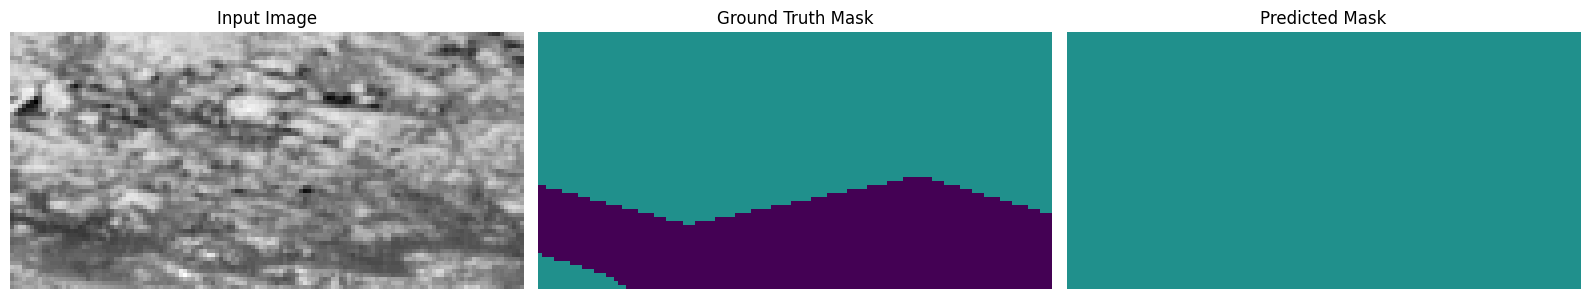

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.7206 - loss: 0.2566 - mean_iou: 0.7758 - val_accuracy: 0.6942 - val_loss: 0.3301 - val_mean_iou: 0.6741
Final validation Mean Intersection Over Union: 69.12%


In [15]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

In [16]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_MultiResNet_{timestep_str}_{str(final_val_meanIoU)}.keras"
model.save(model_filename)


In [17]:
#del model

print(f"Model saved to {model_filename}")

Model saved to model_MultiResNet_241214_173803_69.12.keras


## Results

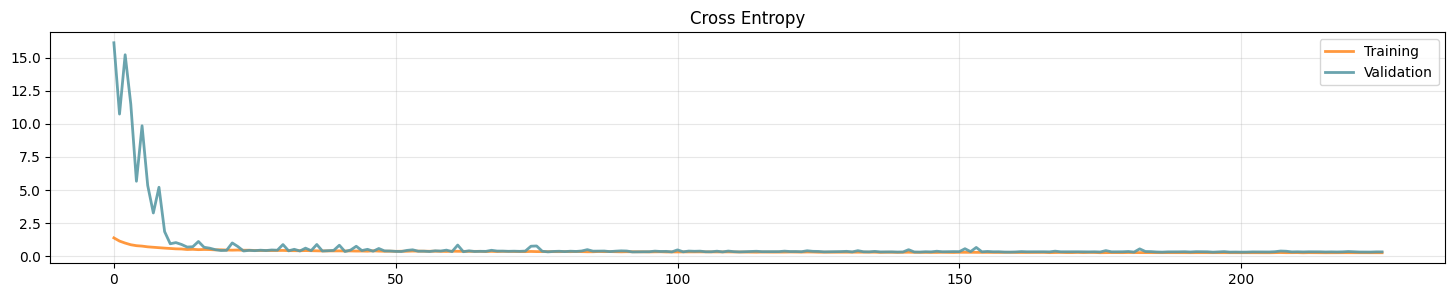

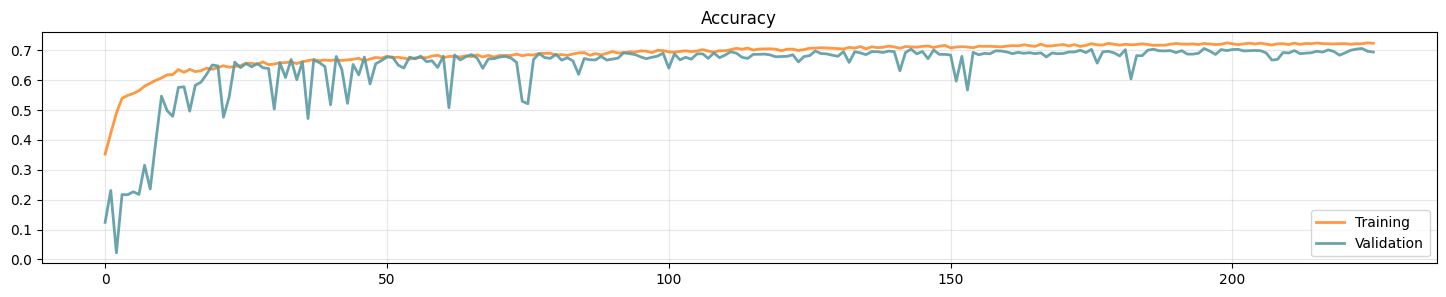

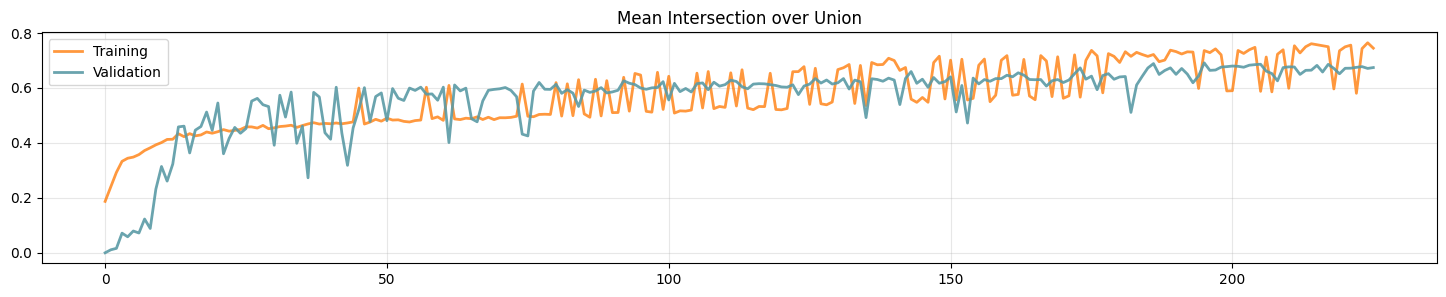

In [18]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [19]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [20]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 64, 128, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_2'}, 'registered_name': None, 'name': 'input_layer_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_122', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 8, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 1]}, 'name': 'conv2d_122', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 1], 'dtype': 'float32', 'keras_history': ['input_layer_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_150', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 8]}, 'name': 'batch_normalization_150', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['conv2d_122', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_112', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 8]}, 'name': 'activation_112', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['batch_normalization_150', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_123', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 17, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 8]}, 'name': 'conv2d_123', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['activation_112', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_151', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 17]}, 'name': 'batch_normalization_151', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['conv2d_123', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_113', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 17]}, 'name': 'activation_113', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['batch_normalization_151', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_124', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 26, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 17]}, 'name': 'conv2d_124', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['activation_113', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_152', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 26]}, 'name': 'batch_normalization_152', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 26], 'dtype': 'float32', 'keras_history': ['conv2d_124', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_114', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 26]}, 'name': 'activation_114', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 26], 'dtype': 'float32', 'keras_history': ['batch_normalization_152', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_121', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 51, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 1]}, 'name': 'conv2d_121', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 1], 'dtype': 'float32', 'keras_history': ['input_layer_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_18', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 8], [None, 64, 128, 17], [None, 64, 128, 26]]}, 'name': 'concatenate_18', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['activation_112', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['activation_113', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 26], 'dtype': 'float32', 'keras_history': ['activation_114', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_149', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'batch_normalization_149', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['conv2d_121', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_153', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'batch_normalization_153', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['concatenate_18', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_39', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 51], [None, 64, 128, 51]]}, 'name': 'add_39', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_149', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_153', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_115', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'activation_115', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['add_39', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_154', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'batch_normalization_154', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['activation_115', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'max_pooling2d_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_154', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_134', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 17, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 51]}, 'name': 'conv2d_134', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 51], 'dtype': 'float32', 'keras_history': ['max_pooling2d_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_168', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 17]}, 'name': 'batch_normalization_168', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['conv2d_134', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_124', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 17]}, 'name': 'activation_124', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['batch_normalization_168', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_135', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 35, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 17]}, 'name': 'conv2d_135', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['activation_124', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_169', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 35]}, 'name': 'batch_normalization_169', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['conv2d_135', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_125', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 35]}, 'name': 'activation_125', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['batch_normalization_169', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_136', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 53, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 35]}, 'name': 'conv2d_136', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['activation_125', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_170', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 53]}, 'name': 'batch_normalization_170', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 53], 'dtype': 'float32', 'keras_history': ['conv2d_136', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_126', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 53]}, 'name': 'activation_126', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 53], 'dtype': 'float32', 'keras_history': ['batch_normalization_170', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_133', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 105, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 51]}, 'name': 'conv2d_133', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 51], 'dtype': 'float32', 'keras_history': ['max_pooling2d_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_19', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 17], [None, 32, 64, 35], [None, 32, 64, 53]]}, 'name': 'concatenate_19', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['activation_124', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['activation_125', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 53], 'dtype': 'float32', 'keras_history': ['activation_126', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_167', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'batch_normalization_167', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['conv2d_133', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_171', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'batch_normalization_171', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['concatenate_19', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_44', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 105], [None, 32, 64, 105]]}, 'name': 'add_44', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_167', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_171', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_127', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'activation_127', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['add_44', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_172', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'batch_normalization_172', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['activation_127', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'max_pooling2d_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_172', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_144', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 35, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 105]}, 'name': 'conv2d_144', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 105], 'dtype': 'float32', 'keras_history': ['max_pooling2d_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_183', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 35]}, 'name': 'batch_normalization_183', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['conv2d_144', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_134', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 35]}, 'name': 'activation_134', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['batch_normalization_183', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_145', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 71, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 35]}, 'name': 'conv2d_145', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['activation_134', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_184', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 71]}, 'name': 'batch_normalization_184', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['conv2d_145', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_135', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 71]}, 'name': 'activation_135', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['batch_normalization_184', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_146', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 106, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 71]}, 'name': 'conv2d_146', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['activation_135', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_185', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 106]}, 'name': 'batch_normalization_185', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 106], 'dtype': 'float32', 'keras_history': ['conv2d_146', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_136', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 106]}, 'name': 'activation_136', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 106], 'dtype': 'float32', 'keras_history': ['batch_normalization_185', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_143', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 212, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 105]}, 'name': 'conv2d_143', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 105], 'dtype': 'float32', 'keras_history': ['max_pooling2d_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_20', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 35], [None, 16, 32, 71], [None, 16, 32, 106]]}, 'name': 'concatenate_20', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['activation_134', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['activation_135', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 106], 'dtype': 'float32', 'keras_history': ['activation_136', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_182', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'batch_normalization_182', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['conv2d_143', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_186', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'batch_normalization_186', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['concatenate_20', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_48', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 212], [None, 16, 32, 212]]}, 'name': 'add_48', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_182', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_186', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_137', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'activation_137', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['add_48', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_187', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'batch_normalization_187', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['activation_137', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'max_pooling2d_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_187', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_152', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 71, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 212]}, 'name': 'conv2d_152', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 212], 'dtype': 'float32', 'keras_history': ['max_pooling2d_10', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_195', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 71]}, 'name': 'batch_normalization_195', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['conv2d_152', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_142', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 71]}, 'name': 'activation_142', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['batch_normalization_195', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_153', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 142, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 71]}, 'name': 'conv2d_153', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['activation_142', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_196', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 142]}, 'name': 'batch_normalization_196', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['conv2d_153', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_143', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 142]}, 'name': 'activation_143', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['batch_normalization_196', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_154', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 213, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 142]}, 'name': 'conv2d_154', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['activation_143', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_197', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 213]}, 'name': 'batch_normalization_197', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 213], 'dtype': 'float32', 'keras_history': ['conv2d_154', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_144', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 213]}, 'name': 'activation_144', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 213], 'dtype': 'float32', 'keras_history': ['batch_normalization_197', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_151', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 426, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 212]}, 'name': 'conv2d_151', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 212], 'dtype': 'float32', 'keras_history': ['max_pooling2d_10', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_21', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 71], [None, 8, 16, 142], [None, 8, 16, 213]]}, 'name': 'concatenate_21', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['activation_142', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['activation_143', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 213], 'dtype': 'float32', 'keras_history': ['activation_144', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_194', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'batch_normalization_194', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['conv2d_151', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_198', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'batch_normalization_198', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['concatenate_21', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_51', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 426], [None, 8, 16, 426]]}, 'name': 'add_51', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_194', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_198', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_145', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'activation_145', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['add_51', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_199', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'batch_normalization_199', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['activation_145', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'max_pooling2d_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_199', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_158', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 142, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 426]}, 'name': 'conv2d_158', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 426], 'dtype': 'float32', 'keras_history': ['max_pooling2d_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_204', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 142]}, 'name': 'batch_normalization_204', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 142], 'dtype': 'float32', 'keras_history': ['conv2d_158', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_148', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 142]}, 'name': 'activation_148', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 142], 'dtype': 'float32', 'keras_history': ['batch_normalization_204', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_159', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 284, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 142]}, 'name': 'conv2d_159', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 142], 'dtype': 'float32', 'keras_history': ['activation_148', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_205', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 284]}, 'name': 'batch_normalization_205', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 284], 'dtype': 'float32', 'keras_history': ['conv2d_159', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_149', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 284]}, 'name': 'activation_149', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 284], 'dtype': 'float32', 'keras_history': ['batch_normalization_205', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_160', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 427, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 284]}, 'name': 'conv2d_160', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 284], 'dtype': 'float32', 'keras_history': ['activation_149', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_206', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 427]}, 'name': 'batch_normalization_206', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 427], 'dtype': 'float32', 'keras_history': ['conv2d_160', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_150', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 427]}, 'name': 'activation_150', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 427], 'dtype': 'float32', 'keras_history': ['batch_normalization_206', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_157', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 853, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 426]}, 'name': 'conv2d_157', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 426], 'dtype': 'float32', 'keras_history': ['max_pooling2d_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_22', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 4, 8, 142], [None, 4, 8, 284], [None, 4, 8, 427]]}, 'name': 'concatenate_22', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 142], 'dtype': 'float32', 'keras_history': ['activation_148', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 284], 'dtype': 'float32', 'keras_history': ['activation_149', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 427], 'dtype': 'float32', 'keras_history': ['activation_150', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_203', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'batch_normalization_203', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['conv2d_157', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_207', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'batch_normalization_207', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['concatenate_22', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_53', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 4, 8, 853], [None, 4, 8, 853]]}, 'name': 'add_53', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['batch_normalization_203', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['batch_normalization_207', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_156', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'conv2d_156', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_199', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_151', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'activation_151', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['add_53', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_155', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'conv2d_155', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_199', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_201', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'batch_normalization_201', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_156', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_208', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'batch_normalization_208', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['activation_151', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_200', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'batch_normalization_200', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_155', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_146', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'activation_146', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_201', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_161', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'conv2d_161', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['batch_normalization_208', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_52', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 256], [None, 8, 16, 256]]}, 'name': 'add_52', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_200', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['activation_146', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_152', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 256]}, 'name': 'activation_152', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['conv2d_161', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_147', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'activation_147', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['add_52', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_163', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 256]}, 'name': 'conv2d_163', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['activation_152', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_202', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'batch_normalization_202', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['activation_147', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 256]}, 'name': 'conv2d_transpose_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['conv2d_163', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_162', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 256, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'conv2d_162', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_202', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_54', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 4, 8, 256], [None, 4, 8, 256]]}, 'name': 'add_54', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_9', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['conv2d_162', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_153', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 256]}, 'name': 'activation_153', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['add_54', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_164', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 256]}, 'name': 'conv2d_164', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['activation_153', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_154', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'sigmoid'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 1]}, 'name': 'activation_154', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 1], 'dtype': 'float32', 'keras_history': ['conv2d_164', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'size': [2, 2], 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 1]}, 'name': 'up_sampling2d_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 1], 'dtype': 'float32', 'keras_history': ['activation_154', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'RepeatElementsLayer', 'config': {'name': 'repeat_elements_layer_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'rep': 256, 'axis': 3}, 'registered_name': 'RepeatElementsLayer', 'build_config': {'input_shape': [None, 8, 16, 1]}, 'name': 'repeat_elements_layer_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 1], 'dtype': 'float32', 'keras_history': ['up_sampling2d_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 256], [None, 8, 16, 256]]}, 'name': 'multiply_4', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['repeat_elements_layer_4', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_202', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_165', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'conv2d_165', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['multiply_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 256, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'conv2d_transpose_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['batch_normalization_208', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_209', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'batch_normalization_209', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_165', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_23', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 256], [None, 8, 16, 256]]}, 'name': 'concatenate_23', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_10', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_209', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_167', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 71, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 512]}, 'name': 'conv2d_167', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 512], 'dtype': 'float32', 'keras_history': ['concatenate_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_211', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 71]}, 'name': 'batch_normalization_211', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['conv2d_167', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_155', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 71]}, 'name': 'activation_155', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['batch_normalization_211', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_168', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 142, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 71]}, 'name': 'conv2d_168', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['activation_155', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_212', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 142]}, 'name': 'batch_normalization_212', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['conv2d_168', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_156', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 142]}, 'name': 'activation_156', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['batch_normalization_212', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_148', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'conv2d_148', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_187', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_169', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 213, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 142]}, 'name': 'conv2d_169', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['activation_156', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_147', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'conv2d_147', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_187', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_189', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_189', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_148', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_213', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 213]}, 'name': 'batch_normalization_213', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 213], 'dtype': 'float32', 'keras_history': ['conv2d_169', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_188', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_188', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_147', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_138', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'activation_138', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_189', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_157', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 213]}, 'name': 'activation_157', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 213], 'dtype': 'float32', 'keras_history': ['batch_normalization_213', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_49', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 128], [None, 16, 32, 128]]}, 'name': 'add_49', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_188', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['activation_138', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_166', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 426, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 512]}, 'name': 'conv2d_166', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 512], 'dtype': 'float32', 'keras_history': ['concatenate_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_24', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 71], [None, 8, 16, 142], [None, 8, 16, 213]]}, 'name': 'concatenate_24', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['activation_155', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['activation_156', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 213], 'dtype': 'float32', 'keras_history': ['activation_157', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_139', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'activation_139', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['add_49', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_210', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'batch_normalization_210', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['conv2d_166', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_214', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'batch_normalization_214', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['concatenate_24', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_190', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_190', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['activation_139', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_55', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 426], [None, 8, 16, 426]]}, 'name': 'add_55', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_210', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_214', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_150', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'conv2d_150', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_190', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_158', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'activation_158', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['add_55', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_149', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'conv2d_149', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_190', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_192', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_192', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_150', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_215', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'batch_normalization_215', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['activation_158', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_191', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_191', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_149', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_140', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'activation_140', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_192', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_170', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'conv2d_170', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_215', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_50', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 128], [None, 16, 32, 128]]}, 'name': 'add_50', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_191', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['activation_140', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_159', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 128]}, 'name': 'activation_159', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['conv2d_170', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_141', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'activation_141', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['add_50', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_172', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 128]}, 'name': 'conv2d_172', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['activation_159', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_193', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_193', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['activation_141', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 128]}, 'name': 'conv2d_transpose_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['conv2d_172', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_171', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 128, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'conv2d_171', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_193', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_56', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 128], [None, 8, 16, 128]]}, 'name': 'add_56', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_11', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['conv2d_171', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_160', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 128]}, 'name': 'activation_160', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['add_56', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_173', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 128]}, 'name': 'conv2d_173', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['activation_160', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_161', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'sigmoid'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 1]}, 'name': 'activation_161', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 1], 'dtype': 'float32', 'keras_history': ['conv2d_173', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'size': [2, 2], 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 1]}, 'name': 'up_sampling2d_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 1], 'dtype': 'float32', 'keras_history': ['activation_161', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'RepeatElementsLayer', 'config': {'name': 'repeat_elements_layer_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'rep': 128, 'axis': 3}, 'registered_name': 'RepeatElementsLayer', 'build_config': {'input_shape': [None, 16, 32, 1]}, 'name': 'repeat_elements_layer_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 1], 'dtype': 'float32', 'keras_history': ['up_sampling2d_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 128], [None, 16, 32, 128]]}, 'name': 'multiply_5', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['repeat_elements_layer_5', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_193', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_174', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'conv2d_174', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['multiply_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 128, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'conv2d_transpose_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_215', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_216', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_216', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_174', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_25', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 128], [None, 16, 32, 128]]}, 'name': 'concatenate_25', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_12', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_216', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_138', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'conv2d_138', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_172', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_176', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 35, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 256]}, 'name': 'conv2d_176', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 256], 'dtype': 'float32', 'keras_history': ['concatenate_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_137', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'conv2d_137', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_172', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_174', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_174', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_138', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_218', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 35]}, 'name': 'batch_normalization_218', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['conv2d_176', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_173', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_173', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_137', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_128', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'activation_128', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_174', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_162', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 35]}, 'name': 'activation_162', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['batch_normalization_218', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_45', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 64], [None, 32, 64, 64]]}, 'name': 'add_45', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_173', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['activation_128', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_177', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 71, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 35]}, 'name': 'conv2d_177', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['activation_162', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_129', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'activation_129', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['add_45', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_219', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 71]}, 'name': 'batch_normalization_219', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['conv2d_177', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_175', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_175', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['activation_129', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_163', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 71]}, 'name': 'activation_163', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['batch_normalization_219', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_140', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'conv2d_140', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_175', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_178', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 106, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 71]}, 'name': 'conv2d_178', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['activation_163', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_139', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'conv2d_139', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_175', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_177', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_177', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_140', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_220', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 106]}, 'name': 'batch_normalization_220', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 106], 'dtype': 'float32', 'keras_history': ['conv2d_178', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_176', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_176', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_139', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_130', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'activation_130', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_177', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_164', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 106]}, 'name': 'activation_164', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 106], 'dtype': 'float32', 'keras_history': ['batch_normalization_220', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_46', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 64], [None, 32, 64, 64]]}, 'name': 'add_46', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_176', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['activation_130', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_175', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 212, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 256]}, 'name': 'conv2d_175', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 256], 'dtype': 'float32', 'keras_history': ['concatenate_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_26', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 35], [None, 16, 32, 71], [None, 16, 32, 106]]}, 'name': 'concatenate_26', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['activation_162', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['activation_163', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 106], 'dtype': 'float32', 'keras_history': ['activation_164', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_131', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'activation_131', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['add_46', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_217', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'batch_normalization_217', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['conv2d_175', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_221', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'batch_normalization_221', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['concatenate_26', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_178', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_178', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['activation_131', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_57', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 212], [None, 16, 32, 212]]}, 'name': 'add_57', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_217', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_221', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_142', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'conv2d_142', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_178', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_165', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'activation_165', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['add_57', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_141', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'conv2d_141', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_178', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_180', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_180', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_142', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_222', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'batch_normalization_222', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['activation_165', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_179', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_179', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_141', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_132', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'activation_132', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_180', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_179', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'conv2d_179', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_222', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_47', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 64], [None, 32, 64, 64]]}, 'name': 'add_47', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_179', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['activation_132', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_166', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 64]}, 'name': 'activation_166', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['conv2d_179', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_133', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'activation_133', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['add_47', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_181', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 64]}, 'name': 'conv2d_181', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['activation_166', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_181', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_181', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['activation_133', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 64]}, 'name': 'conv2d_transpose_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['conv2d_181', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_180', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 64, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'conv2d_180', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_181', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_58', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 64], [None, 16, 32, 64]]}, 'name': 'add_58', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_13', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['conv2d_180', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_167', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 64]}, 'name': 'activation_167', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['add_58', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_182', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 64]}, 'name': 'conv2d_182', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['activation_167', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_168', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'sigmoid'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 1]}, 'name': 'activation_168', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 1], 'dtype': 'float32', 'keras_history': ['conv2d_182', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_126', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'conv2d_126', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_154', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'size': [2, 2], 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 1]}, 'name': 'up_sampling2d_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 1], 'dtype': 'float32', 'keras_history': ['activation_168', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_125', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'conv2d_125', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_154', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_156', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_156', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_126', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': None, 'class_name': 'RepeatElementsLayer', 'config': {'name': 'repeat_elements_layer_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'rep': 64, 'axis': 3}, 'registered_name': 'RepeatElementsLayer', 'build_config': {'input_shape': [None, 32, 64, 1]}, 'name': 'repeat_elements_layer_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 1], 'dtype': 'float32', 'keras_history': ['up_sampling2d_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_155', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_155', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_125', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_116', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_116', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_156', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 64], [None, 32, 64, 64]]}, 'name': 'multiply_6', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['repeat_elements_layer_6', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_181', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_40', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 32], [None, 64, 128, 32]]}, 'name': 'add_40', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_155', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_116', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_183', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'conv2d_183', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['multiply_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_117', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_117', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['add_40', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 64, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'conv2d_transpose_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_222', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_223', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_223', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_183', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_157', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_157', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_117', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_27', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 64], [None, 32, 64, 64]]}, 'name': 'concatenate_27', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_14', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_223', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_128', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_128', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_157', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_185', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 17, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 128]}, 'name': 'conv2d_185', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 128], 'dtype': 'float32', 'keras_history': ['concatenate_27', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_127', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_127', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_157', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_159', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_159', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_128', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_225', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 17]}, 'name': 'batch_normalization_225', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['conv2d_185', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_158', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_158', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_127', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_118', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_118', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_159', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_169', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 17]}, 'name': 'activation_169', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['batch_normalization_225', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_41', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 32], [None, 64, 128, 32]]}, 'name': 'add_41', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_158', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_118', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_186', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 35, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 17]}, 'name': 'conv2d_186', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['activation_169', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_119', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_119', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['add_41', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_226', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 35]}, 'name': 'batch_normalization_226', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['conv2d_186', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_160', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_160', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_119', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_170', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 35]}, 'name': 'activation_170', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['batch_normalization_226', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_130', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_130', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_160', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_187', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 53, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 35]}, 'name': 'conv2d_187', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['activation_170', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_129', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_129', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_160', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_162', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_162', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_130', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_227', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 53]}, 'name': 'batch_normalization_227', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 53], 'dtype': 'float32', 'keras_history': ['conv2d_187', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_161', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_161', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_129', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_120', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_120', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_162', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_171', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 53]}, 'name': 'activation_171', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 53], 'dtype': 'float32', 'keras_history': ['batch_normalization_227', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_42', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 32], [None, 64, 128, 32]]}, 'name': 'add_42', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_161', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_120', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_184', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 105, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 128]}, 'name': 'conv2d_184', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 128], 'dtype': 'float32', 'keras_history': ['concatenate_27', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_28', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 17], [None, 32, 64, 35], [None, 32, 64, 53]]}, 'name': 'concatenate_28', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['activation_169', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['activation_170', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 53], 'dtype': 'float32', 'keras_history': ['activation_171', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_121', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_121', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['add_42', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_224', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'batch_normalization_224', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['conv2d_184', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_228', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'batch_normalization_228', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['concatenate_28', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_163', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_163', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_121', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_59', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 105], [None, 32, 64, 105]]}, 'name': 'add_59', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_224', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_228', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_132', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_132', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_163', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_172', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'activation_172', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['add_59', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_131', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_131', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_163', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_165', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_165', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_132', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_229', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'batch_normalization_229', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['activation_172', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_164', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_164', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_131', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_122', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_122', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_165', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_188', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'conv2d_188', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_229', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_43', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 32], [None, 64, 128, 32]]}, 'name': 'add_43', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_164', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_122', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_173', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 32]}, 'name': 'activation_173', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['conv2d_188', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_123', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_123', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['add_43', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_190', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 32]}, 'name': 'conv2d_190', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['activation_173', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_166', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_166', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_123', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 32]}, 'name': 'conv2d_transpose_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['conv2d_190', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_189', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_189', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_166', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_60', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 32], [None, 32, 64, 32]]}, 'name': 'add_60', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_15', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['conv2d_189', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_174', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 32]}, 'name': 'activation_174', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['add_60', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_191', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 32]}, 'name': 'conv2d_191', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['activation_174', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_175', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'sigmoid'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 1]}, 'name': 'activation_175', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 1], 'dtype': 'float32', 'keras_history': ['conv2d_191', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'size': [2, 2], 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 1]}, 'name': 'up_sampling2d_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 1], 'dtype': 'float32', 'keras_history': ['activation_175', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'RepeatElementsLayer', 'config': {'name': 'repeat_elements_layer_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'rep': 32, 'axis': 3}, 'registered_name': 'RepeatElementsLayer', 'build_config': {'input_shape': [None, 64, 128, 1]}, 'name': 'repeat_elements_layer_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 1], 'dtype': 'float32', 'keras_history': ['up_sampling2d_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 32], [None, 64, 128, 32]]}, 'name': 'multiply_7', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['repeat_elements_layer_7', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_166', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_192', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_192', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['multiply_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 32, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'conv2d_transpose_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_229', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_230', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_230', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_192', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_29', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 32], [None, 64, 128, 32]]}, 'name': 'concatenate_29', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_16', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_230', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_194', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 8, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 64]}, 'name': 'conv2d_194', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 64], 'dtype': 'float32', 'keras_history': ['concatenate_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_232', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 8]}, 'name': 'batch_normalization_232', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['conv2d_194', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_176', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 8]}, 'name': 'activation_176', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['batch_normalization_232', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_195', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 17, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 8]}, 'name': 'conv2d_195', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['activation_176', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_233', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 17]}, 'name': 'batch_normalization_233', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['conv2d_195', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_177', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 17]}, 'name': 'activation_177', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['batch_normalization_233', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_196', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 26, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 17]}, 'name': 'conv2d_196', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['activation_177', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_234', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 26]}, 'name': 'batch_normalization_234', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 26], 'dtype': 'float32', 'keras_history': ['conv2d_196', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_178', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 26]}, 'name': 'activation_178', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 26], 'dtype': 'float32', 'keras_history': ['batch_normalization_234', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_193', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 51, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 64]}, 'name': 'conv2d_193', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 64], 'dtype': 'float32', 'keras_history': ['concatenate_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_30', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 8], [None, 64, 128, 17], [None, 64, 128, 26]]}, 'name': 'concatenate_30', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['activation_176', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['activation_177', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 26], 'dtype': 'float32', 'keras_history': ['activation_178', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_231', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'batch_normalization_231', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['conv2d_193', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_235', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'batch_normalization_235', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['concatenate_30', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_61', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 51], [None, 64, 128, 51]]}, 'name': 'add_61', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_231', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_235', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_179', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'activation_179', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['add_61', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_236', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'batch_normalization_236', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['activation_179', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_197', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'filters': 5, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'conv2d_197', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_236', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_237', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 5]}, 'name': 'batch_normalization_237', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 5], 'dtype': 'float32', 'keras_history': ['conv2d_197', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_180', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'activation': 'softmax'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 5]}, 'name': 'activation_180', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 5], 'dtype': 'float32', 'keras_history': ['batch_normalization_237', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_2', 0, 0]], 'output_layers': [['activation_180', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': None}.

Exception encountered: Could not locate class 'RepeatElementsLayer'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'RepeatElementsLayer', 'config': {'name': 'repeat_elements_layer_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139804534236080}, 'rep': 256, 'axis': 3}, 'registered_name': 'RepeatElementsLayer', 'build_config': {'input_shape': [None, 8, 16, 1]}, 'name': 'repeat_elements_layer_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 1], 'dtype': 'float32', 'keras_history': ['up_sampling2d_5', 0, 0]}}], 'kwargs': {}}]}

In [21]:
preds = model.predict(X_test)
predicted_classes = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes

preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")


314/314 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step
Predictions shape: (10022, 64, 128, 5)
Predictions shape: (10022, 64, 128)


In [22]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [23]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install git+https://github.com/qubvel/tta_wrapper/

In [37]:
import tensorflow as tf

def get_aug_img_v1(image):
    """ Get augmented image

    Args:
        image (tf.tensor): Tensor of type tf.float32 of shape BxHxWxC

    Returns:
        tf.tensor: Tensor of type tf.float32 of shape B*5xHxWxC
    """
    aug_images = tf.concat([
        image,  # Original
        tf.image.flip_up_down(image),  # Vertical flip
        tf.image.flip_left_right(image),  # Horizontal flip
        tf.image.random_brightness(image, max_delta=0.2),  # Random brightness adjustment
        tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast adjustment
    ], axis=0)

    return aug_images

def get_deaug_images_v1(image):
    """Get deaugmented mask or image

    Args:
        image (tf.tensor): Model output goes here. It is of the shape B*5xHxWxC' where C' is the number
        of channels in the model output

    Returns:
        tf.tensor: Shape BxHxWxC'
    """
    print(image.shape)
    i1, i2, i3, i4, i5 = tf.split(image, num_or_size_splits=5, axis=0)
    deaug_img = tf.stack([
        i1,  # Original
        tf.image.flip_up_down(i2),
        tf.image.flip_left_right(i3),
        i4,  # Brightness (cannot undo but averaged out)
        i5   # Contrast (cannot undo but averaged out)
    ], axis=0)

    out = tf.math.reduce_mean(deaug_img, axis=0)
    return out

def infer_with_tta(model, input):
    """ Get output after performing test time augmentation

    Args:
        model (keras model): The model to infer with
        input (tf.tensor): Tensor of shape BxHxWxC

    Returns:
        tf.tensor: Model output
    """
    return get_deaug_images_v1(model(get_aug_img_v1(input)))

class TTAug(tf.keras.layers.Layer):
    def __init__(self):
        """Keras layer for augmentation"""
        super().__init__()

    @tf.function
    def get_aug_img_v1(self, img):
        return get_aug_img_v1(img)

    def call(self, image):
        img_aug = self.get_aug_img_v1(image)
        return img_aug

class TTDeAug(tf.keras.layers.Layer):
    def __init__(self):
        """ Keras layer for de-augmentation"""
        super().__init__()

    @tf.function
    def get_deaug_images_v1(self, img):
        return get_deaug_images_v1(img)

    def call(self, image):
        print(image.shape)
        img_deaug = self.get_deaug_images_v1(image)
        return img_deaug


In [40]:
from keras.models import load_model

print(model.input)
# aug_layer = TTAug()
# deaug_layer = TTDeAug()
# x = tf.keras.layers.Input(shape = (None, None, model.input[0].shape[-1]))
# x_aug = aug_layer(x)
# out = model(x_aug)
# output_deaug = deaug_layer(out)
# tta_model = tf.keras.Model(inputs = x, outputs = output_deaug)
tta_preds = infer_with_tta(model, X_test)
tta_predicted_classes = np.argmax(tta_preds, axis=-1)

print(f"Predictions shape: {tta_preds.shape}")
tta_preds[tta_predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes

tta_preds = np.argmax(tta_preds, axis=-1)

# Create and download the csv submission file
tta_submission_filename = f"tta_submission_{timestep_str}.csv"
tta_submission_df = y_to_df(tta_preds)
tta_submission_df.to_csv(tta_submission_filename, index=False)

from google.colab import files
files.download(tta_submission_filename)


[<KerasTensor shape=(None, 64, 128, 1), dtype=float32, sparse=False, name=keras_tensor_471>]


ResourceExhaustedError: Exception encountered when calling Functional.call().

[1m{{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Cast] name: [0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(50110, 64, 128, 1), dtype=float64)
  • training=None
  • mask=None

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```

In [ ]:
import time
import numpy as np
import sounddevice as sd

def generate_noise(duration=1, sample_rate=44100):
    """Génère un bruit blanc de la durée spécifiée."""
    samples = np.random.uniform(-1, 1, size=(duration * sample_rate,))
    return samples

# Paramètres
sample_rate = 44100  # Fréquence d'échantillonnage en Hz

try:
    print("Le bruit infini est en cours... Interrompez l'exécution pour arrêter.")
    while True:
        noise = generate_noise(duration=1, sample_rate=sample_rate)
        sd.play(noise, samplerate=sample_rate)
        time.sleep(1)  # Attendre la fin de chaque segment avant de continuer
except KeyboardInterrupt:
    print("Exécution interrompue.")
    sd.stop()
